#Drive mount and imports

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
current_dir = "/gdrive/My Drive/"

%cd $current_dir

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1SsYTSWVYK18RYEggHgY0ijnOvaI-DARa/ANN-1stChallenge


In [ ]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

f1_average = 'macro'

PyTorch version: 2.8.0+cu126
Device: cpu


# Data Loading

In [ ]:
BASE_PATH = "datasets/"

TRAIN_PATH = BASE_PATH + "pirate_pain_train.csv"
TRAIN_LABELS_PATH = BASE_PATH + "pirate_pain_train_labels.csv"
TEST_PATH = BASE_PATH + "pirate_pain_test.csv"
SUBMISSION_PATH = BASE_PATH + "sample_submission.csv"

X_train = pd.read_csv(TRAIN_PATH)
y_train = pd.read_csv(TRAIN_LABELS_PATH)

X_test = pd.read_csv(TEST_PATH)

## Encoding features

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'label' column in y_train
y_train['label_encoded'] = label_encoder.fit_transform(y_train['label'])

# Display the mapping of original labels to encoded numbers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

y_train = y_train.drop('label', axis=1)

Label Mapping:
{'high_pain': np.int64(0), 'low_pain': np.int64(1), 'no_pain': np.int64(2)}


In [ ]:
from sklearn.preprocessing import LabelEncoder
categorical_features = ['n_legs', 'n_hands', 'n_eyes']

encoders = {}

for col in categorical_features:
    encoders[col] = LabelEncoder()

    X_train[col + '_encoded'] = encoders[col].fit_transform(X_train[col])
    X_test[col + '_encoded'] = encoders[col].transform(X_test[col])

    print(f"Label mapping for {col}: {dict(zip(encoders[col].classes_, encoders[col].transform(encoders[col].classes_)))}")

X_train = X_train.drop(categorical_features, axis=1)
X_test = X_test.drop(categorical_features, axis=1)

Label mapping for n_legs: {'one+peg_leg': np.int64(0), 'two': np.int64(1)}
Label mapping for n_hands: {'one+hook_hand': np.int64(0), 'two': np.int64(1)}
Label mapping for n_eyes: {'one+eye_patch': np.int64(0), 'two': np.int64(1)}


In [ ]:
# Merge X_train and y_train based on 'sample_index'
df = pd.merge(X_train, y_train, on='sample_index')

# Define the columns to drop

#joint_columns_to_drop = [f'joint_{i:02d}' for i in range(13, 26)]
#joint_columns_to_drop.append('joint_30')
pain_survey_columns_to_drop = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
#body_part_columns = ['n_legs_encoded', 'n_hands_encoded', 'n_eyes_encoded']

columns_to_drop = pain_survey_columns_to_drop

# Drop the columns
df = df.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)


In [ ]:
pd.set_option('display.max_columns', None)
df.describe()

sample_index           time  pain_survey_1  pain_survey_2  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean      330.000000      79.500000       1.633746       1.654851   
std       190.814948      46.187338       0.682423       0.669639   
min         0.000000       0.000000       0.000000       0.000000   
25%       165.000000      39.750000       2.000000       2.000000   
50%       330.000000      79.500000       2.000000       2.000000   
75%       495.000000     119.250000       2.000000       2.000000   
max       660.000000     159.000000       2.000000       2.000000   

       pain_survey_3  pain_survey_4       joint_00       joint_01  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean        1.653640       1.663134       0.943095       0.916955   
std         0.666649       0.661994       0.202051       0.197608   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       2.000000       0.828277       0.811445   
50%         2.000000       2.000000       1.005126       0.979468   
75%         2.000000       2.000000       1.081039       1.056611   
max         2.000000       2.000000       1.407968       1.334613   

            joint_02       joint_03       joint_04       joint_05  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean        0.779296       0.767921       0.709186       0.711306   
std         0.295605       0.300787       0.418058       0.411783   
min         0.001015       0.005403       0.000000       0.000000   
25%         0.568850       0.520020       0.184585       0.210551   
50%         0.909549       0.914834       0.930007       0.950628   
75%         0.995187       0.994324       1.036497       1.032400   
max         1.306046       1.254729       1.359204       1.387731   

            joint_06       joint_07       joint_08       joint_09  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean        0.875185       0.837427       0.849700       0.909554   
std         0.240900       0.237904       0.180489       0.180320   
min         0.000000       0.000000       0.122095       0.004671   
25%         0.839166       0.781375       0.717725       0.825898   
50%         0.937363       0.904914       0.831221       0.940954   
75%         1.013150       0.984410       0.991104       1.030941   
max         1.410532       1.361969       1.357288       1.388105   

            joint_10       joint_11       joint_12       joint_13  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean        0.694840       0.691105       1.047287       0.000092   
std         0.257572       0.262645       0.110834       0.001202   
min         0.107917       0.072233       0.107136       0.000000   
25%         0.469688       0.460407       0.983152       0.000000   
50%         0.690806       0.705150       1.057917       0.000001   
75%         0.866482       0.851772       1.124471       0.000006   
max         1.631494       1.464157       1.396754       0.073852   

           joint_14      joint_15      joint_16       joint_17       joint_18  \
count  1.057600e+05  1.057600e+05  1.057600e+05  105760.000000  105760.000000   
mean   8.068677e-05  1.038032e-04  1.085133e-04       0.000351       0.000293   
std    1.481660e-03  1.287669e-03  1.628836e-03       0.004383       0.004987   
min    2.763050e-07  0.000000e+00  0.000000e+00       0.000000       0.000000   
25%    6.538634e-07  0.000000e+00  5.348361e-07       0.000000       0.000000   
50%    2.165072e-06  7.069540e-07  1.825457e-06       0.000002       0.000001   
75%    6.396479e-06  5.481908e-06  6.550744e-06       0.000019       0.000015   
max    2.642323e-01  1.003470e-01  1.888070e-01       0.420947       0.728382   

            joint_19       joint_20      joint_21      joint_22      joint_23  \
count  105760.000000  105760.000000  1.057600e+05  1.057600e+05  1.057600e+05   
mean  

# Downsampling

Removing the sample indexes having the 5 highest values for each joint from 13 to 25

In [ ]:
# Analyzing only joints from 13 to 25
joint_names_to_check = [f'joint_{i:02d}' for i in range(13, 26)]

# Initialize an empty dictionary to store the results
top_samples_by_joint = {}

# Loop through each joint name
for joint_name in joint_names_to_check:
    # Get the 'sample_index' of the 5 rows with the largest values for the current joint
    top_5_rows = df.nlargest(5, joint_name)
    sample_index_list = top_5_rows['sample_index'].tolist()
    # Store the list in the dictionary with the joint name as the key
    top_samples_by_joint[joint_name] = sample_index_list

# Print results
for joint, samples in top_samples_by_joint.items():
    print(f"Top 5 Sample Indexes for {joint}")
    print(samples)
    print("\n")

--- Top 50 Sample Indexes for joint_13 ---
[44, 280, 44, 92, 44]


--- Top 50 Sample Indexes for joint_14 ---
[123, 123, 465, 92, 280]


--- Top 50 Sample Indexes for joint_15 ---
[44, 44, 559, 44, 44]


--- Top 50 Sample Indexes for joint_16 ---
[44, 44, 44, 44, 44]


--- Top 50 Sample Indexes for joint_17 ---
[381, 381, 559, 381, 44]


--- Top 50 Sample Indexes for joint_18 ---
[518, 123, 123, 123, 123]


--- Top 50 Sample Indexes for joint_19 ---
[193, 511, 11, 11, 264]


--- Top 50 Sample Indexes for joint_20 ---
[472, 300, 22, 16, 511]


--- Top 50 Sample Indexes for joint_21 ---
[465, 88, 88, 465, 444]


--- Top 50 Sample Indexes for joint_22 ---
[88, 465, 465, 338, 577]


--- Top 50 Sample Indexes for joint_23 ---
[88, 88, 193, 11, 214]


--- Top 50 Sample Indexes for joint_24 ---
[88, 521, 465, 252, 319]


--- Top 50 Sample Indexes for joint_25 ---
[465, 465, 88, 290, 34]




In [ ]:
# Find the union of all sample indexes

# Initialize an empty set to store the unique sample indexes
union_of_outliers = set()

# Loop through each list of top sample indexes in the dictionary
for sample_list in top_samples_by_joint.values():
    # add all items from the list to the set
    union_of_outliers.update(sample_list)

outlier_samples_to_remove = list(union_of_outliers)

# Print the final list of outliers
print(f"Found {len(outlier_samples_to_remove)} unique sample(s) that appear in the top 50 for at least ONE joint from joint_13 to joint_25.")
print("List of unique outlier sample indexes to remove:")
print(outlier_samples_to_remove[:100])

Found 26 unique sample(s) that appear in the top 50 for at least ONE joint from joint_13 to joint_25.
List of unique outlier sample indexes to remove:
[518, 264, 521, 11, 16, 22, 280, 290, 34, 44, 300, 559, 444, 319, 193, 577, 465, 338, 214, 472, 88, 92, 123, 252, 381, 511]


In [ ]:
df_cleaned = df[~df['sample_index'].isin(outlier_samples_to_remove)]

print("\nVerifying Removal")
print(f"Original DataFrame size: {len(df)}")
print(f"Unique outliers identified: {len(outlier_samples_to_remove)}")
print(f"Cleaned DataFrame size:   {len(df_cleaned)}")
print(f"Number of rows removed:   {len(df) - len(df_cleaned)}")


--- Verifying Removal ---
Original DataFrame size: 105760
Unique outliers identified: 26
Cleaned DataFrame size:   101600
Number of rows removed:   4160


In [ ]:
df=df_cleaned

# Feature correlation

Plotting the feature correlation matrix based on the pearson correlation coefficient

Analyzing the following features:
Index(['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05',
       'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11',
       'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17',
       'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23',
       'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29',
       'joint_30', 'n_legs_encoded', 'n_hands_encoded', 'n_eyes_encoded',
       'label_encoded'],
      dtype='object')


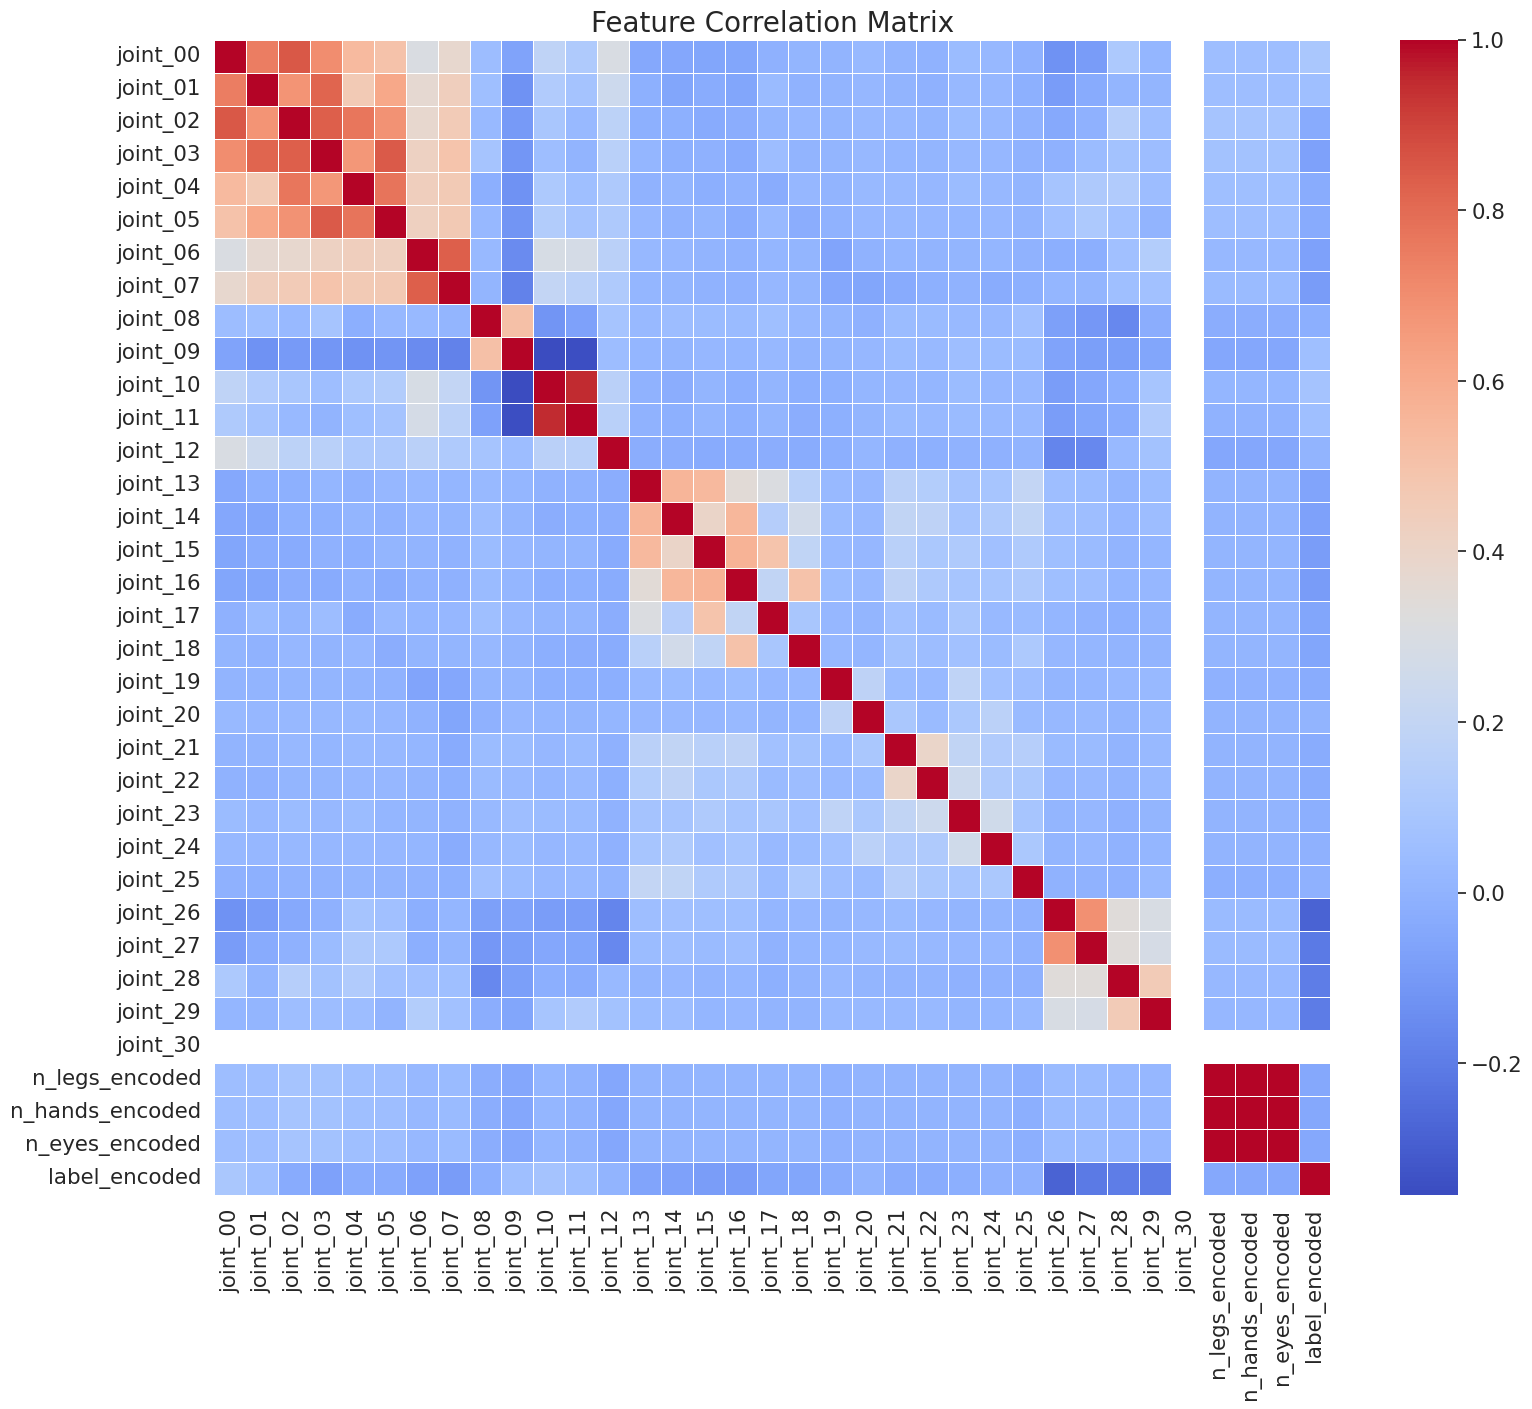

In [ ]:
features_df = df.drop(columns=['sample_index', 'time'])
print("Analyzing the following features:")
print(features_df.columns)

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = features_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(18, 15))

# Draw the heatmap
sns.heatmap(correlation_matrix,
            annot=False,
            cmap='coolwarm',
            linewidths=.5)

plt.title('Feature Correlation Matrix', fontsize=20)
plt.show()

In [ ]:
threshold = 0.90

# Create a boolean mask for pairs above the threshold
# We use abs() to catch both positive and negative correlations
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]

print(f"\nFound {len(to_drop)} features to remove with correlation > {threshold}:")
print(to_drop)

# Drop these columns from your original DataFrame
df = df.drop(columns=to_drop)

#print(f"\nOriginal number of columns: {df.shape[1]}")
print(f"Number of columns after removing redundant features: {df.shape[1]}")


Found 3 features to remove with correlation > 0.9:
['joint_11', 'n_hands_encoded', 'n_eyes_encoded']

Original number of columns: 34
Number of columns after removing redundant features: 34


# Row duplicates

In [ ]:
# Count the number of complete duplicate rows
num_duplicates = df.duplicated().sum()

print(f"Found {num_duplicates} complete duplicate rows.")

Found 0 complete duplicate rows.


# Plotting distribution for surveys, joints, body parts

Displaying NORMALIZED distribution plots for the pain survey columns:


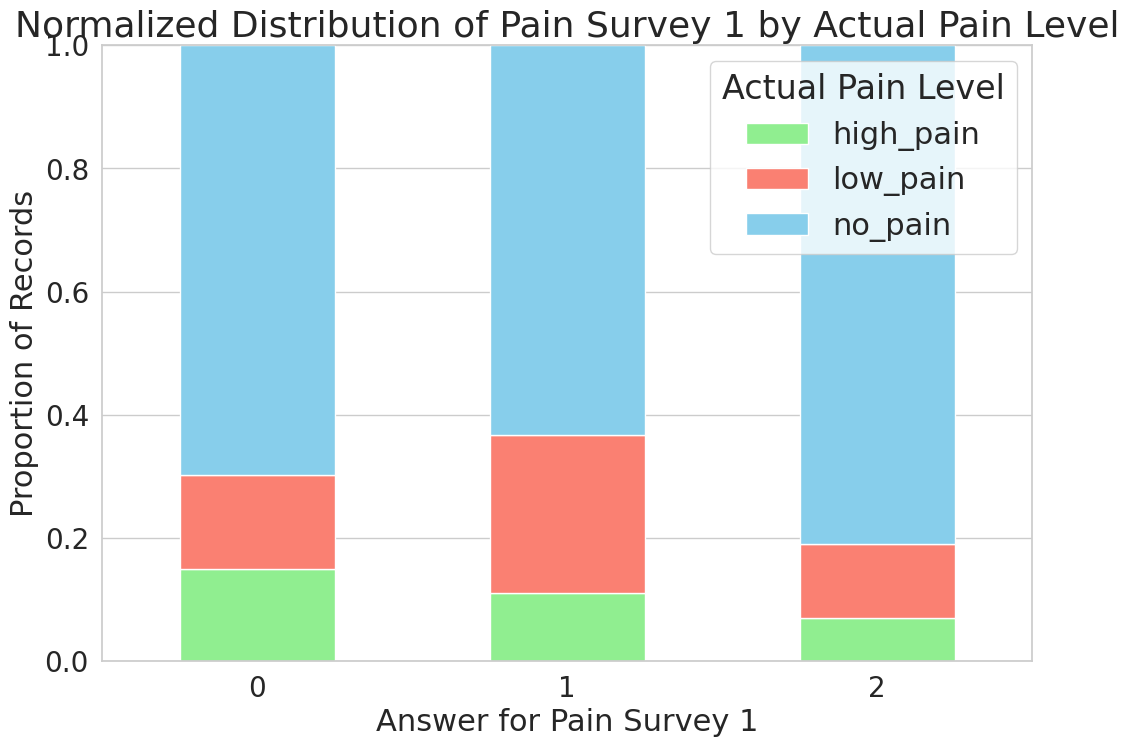

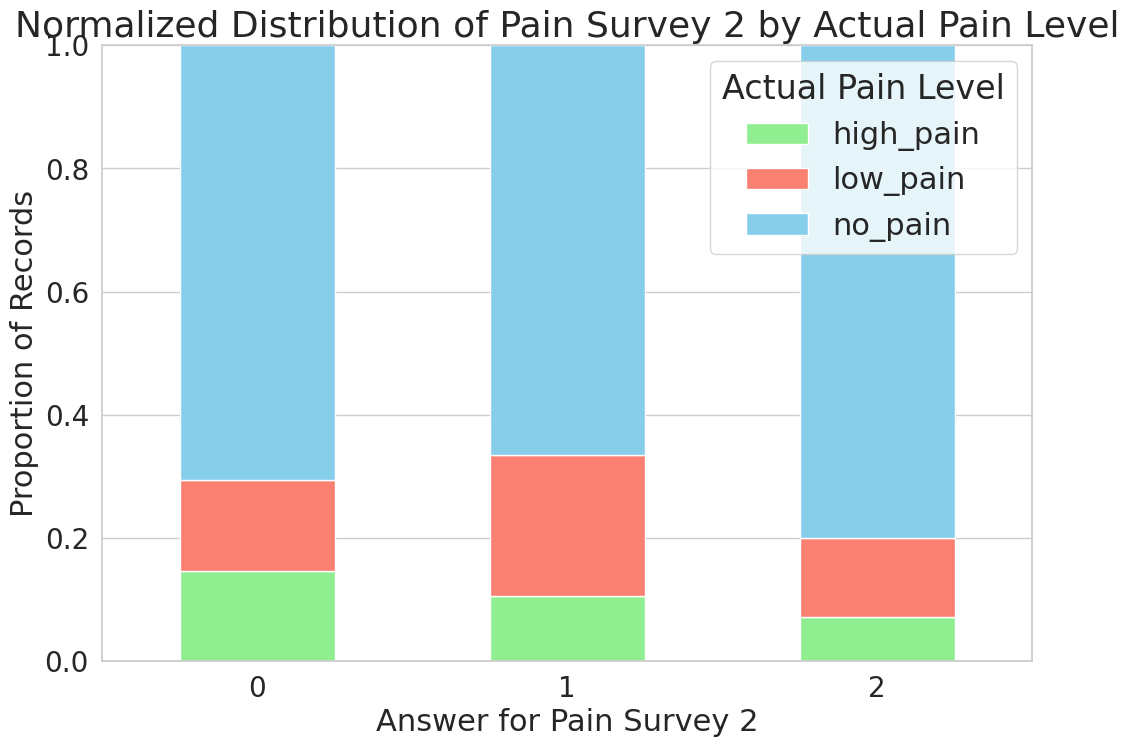

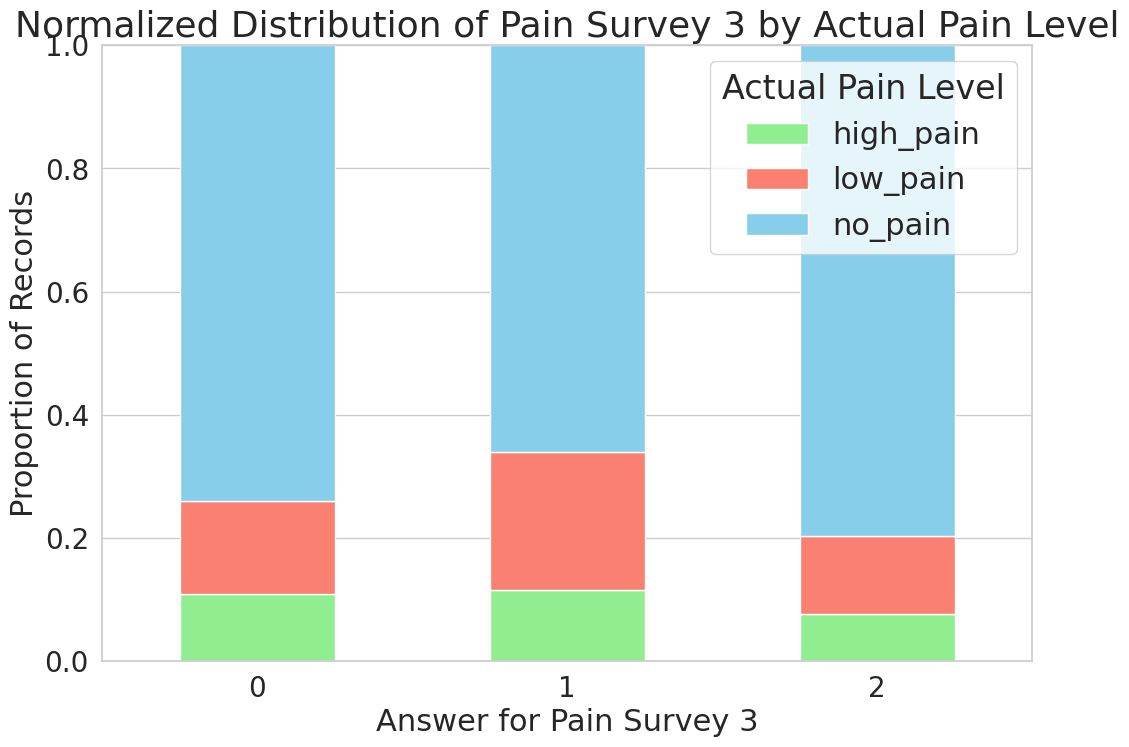

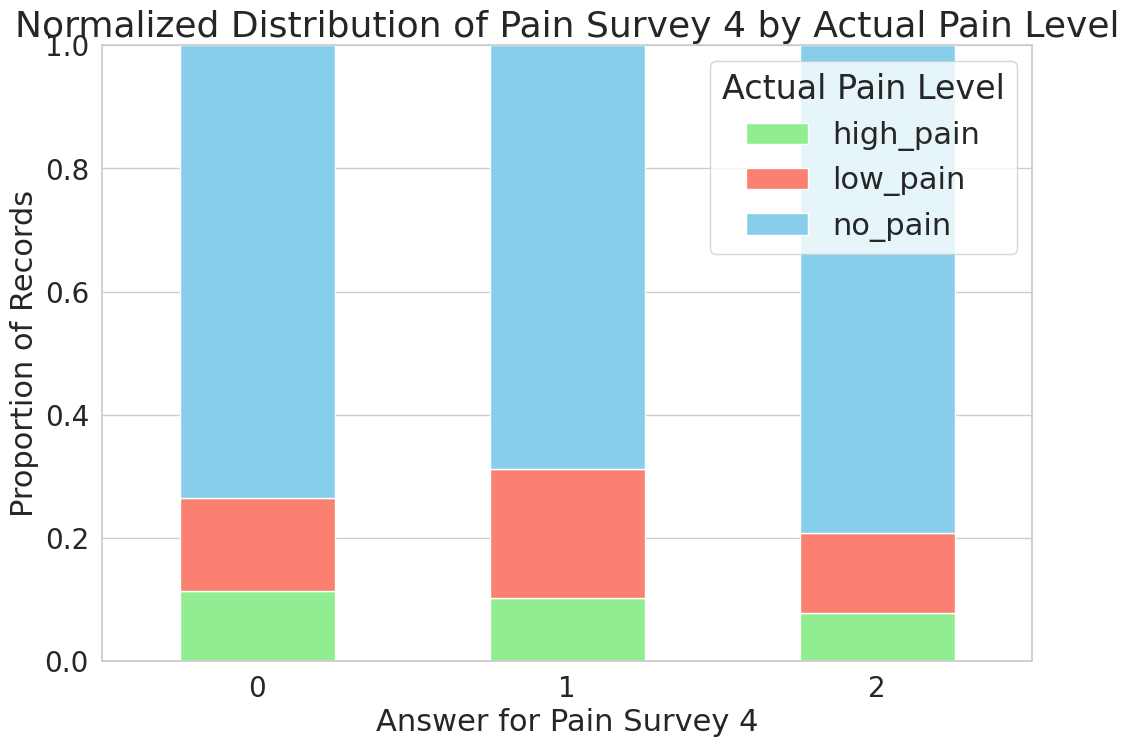

In [ ]:
# PLOTTING SURBEYS DISTRIBUTIONS BY LABEL
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

X_train_original = pd.read_csv("datasets/pirate_pain_train.csv")
y_train_original = pd.read_csv("datasets/pirate_pain_train_labels.csv")
df_for_plotting = pd.merge(X_train_original, y_train_original, on='sample_index')


# Identify the pain survey columns
pain_survey_columns = [col for col in df_for_plotting.columns if col.startswith('pain_survey')]

sns.set(style="whitegrid", font_scale=1.5)
palette = {"no_pain": "skyblue", "low_pain": "salmon", "high_pain": "lightgreen"}

print("Displaying NORMALIZED distribution plots for the pain survey columns:")
for survey in pain_survey_columns:
    # Group by the survey answer, then get the value counts of the labels and normalize
    props = df_for_plotting.groupby(survey)['label'].value_counts(normalize=True).unstack()
    props.plot(kind='bar', stacked=True, color=[palette[col] for col in props.columns], figsize=(12, 8))

    plt.title(f'Normalized Distribution of {survey.replace("_", " ").title()} by Actual Pain Level', fontsize=26)
    plt.xlabel(f'Answer for {survey.replace("_", " ").title()}', fontsize=22)
    plt.ylabel('Proportion of Records', fontsize=22)

    plt.legend(title='Actual Pain Level', fontsize=22, title_fontsize=24)

    plt.xticks(rotation=0, fontsize=20)
    plt.yticks(fontsize=20)

    # y-axis is from 0 to 1 (representing 0% to 100%)
    plt.ylim(0, 1)

    plt.show()

sns.set()

Displaying distribution plots for the first 6 joints:


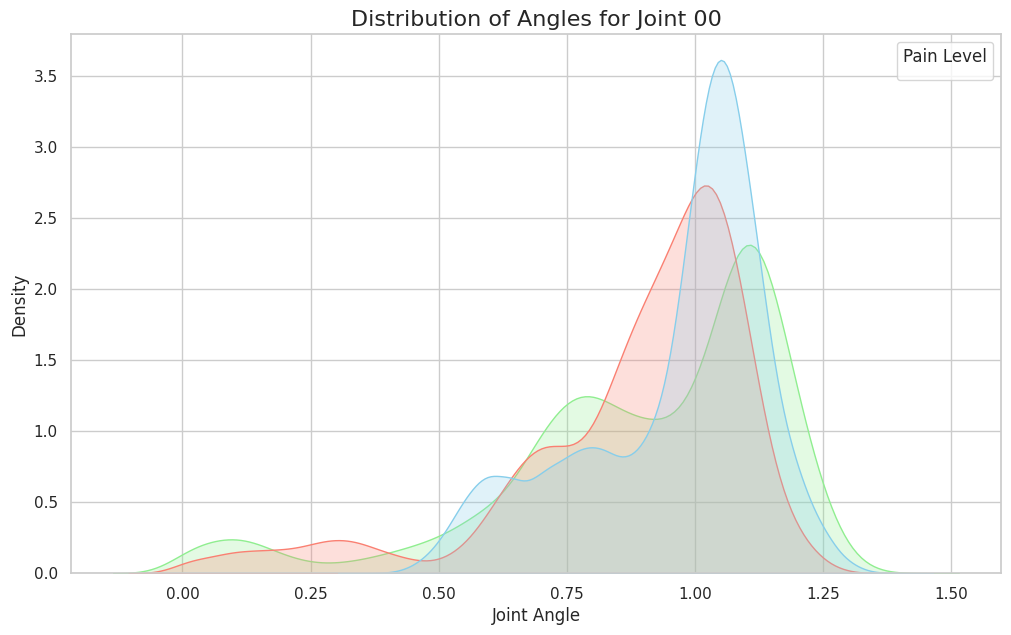

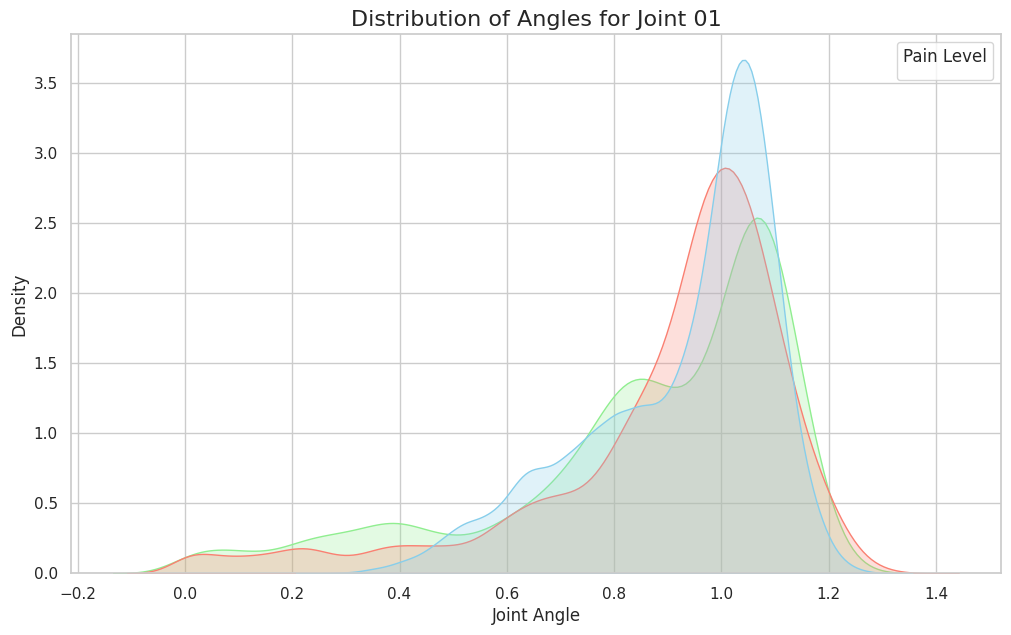

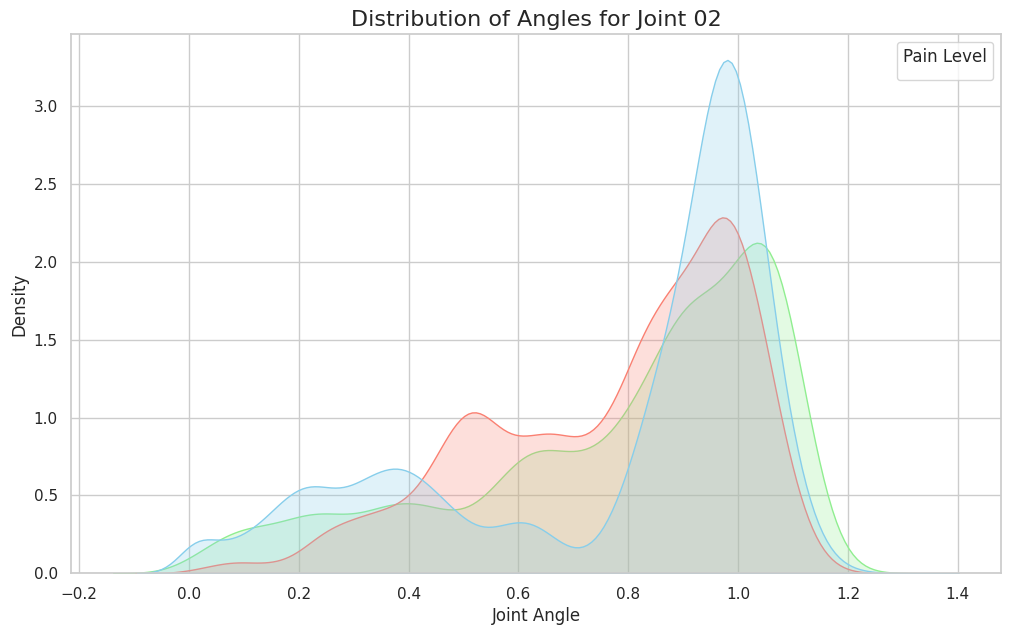

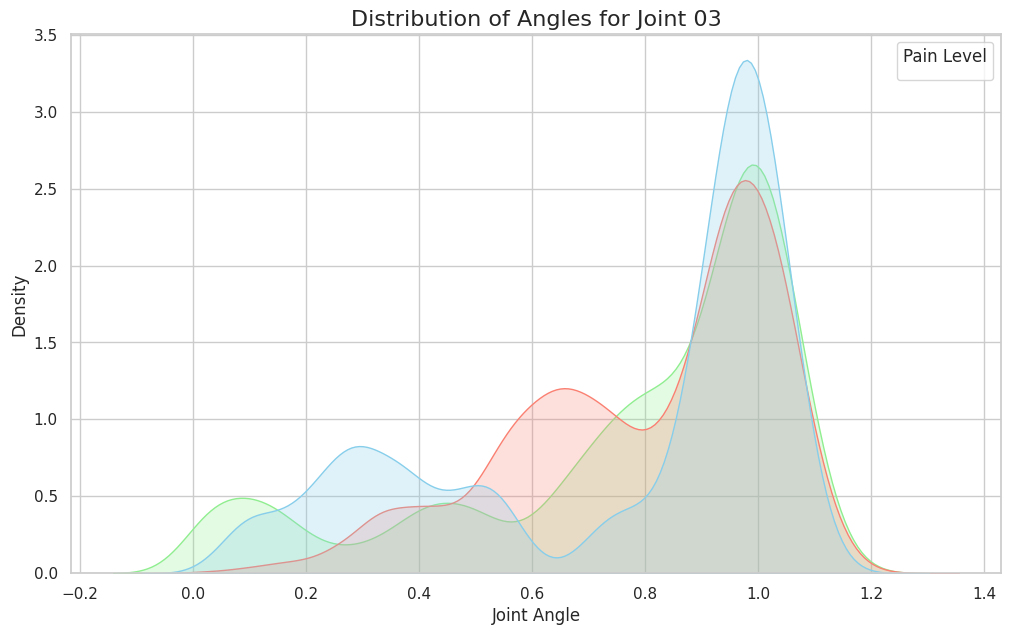

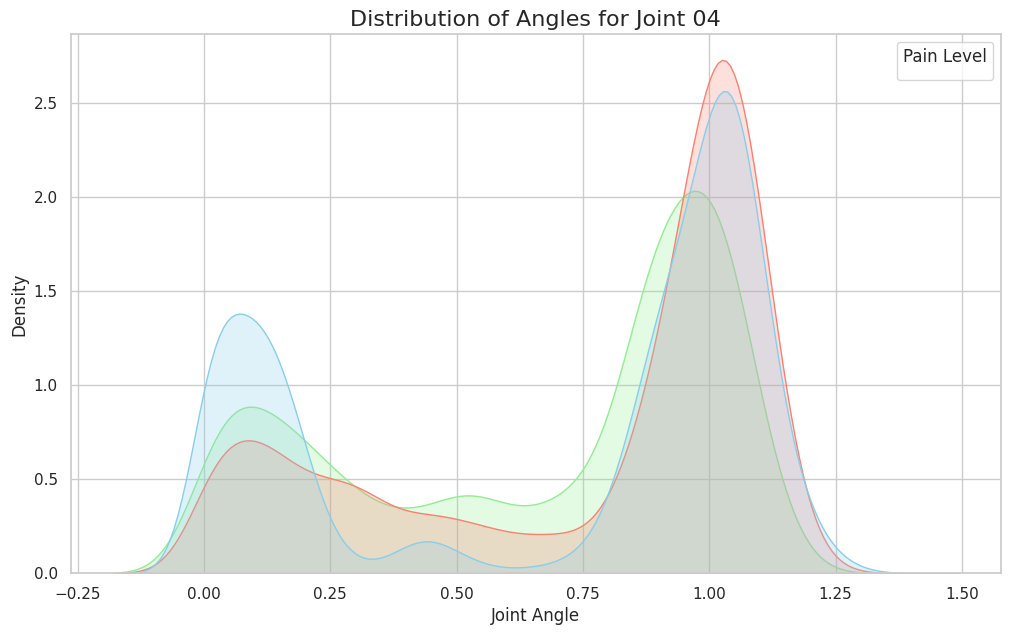

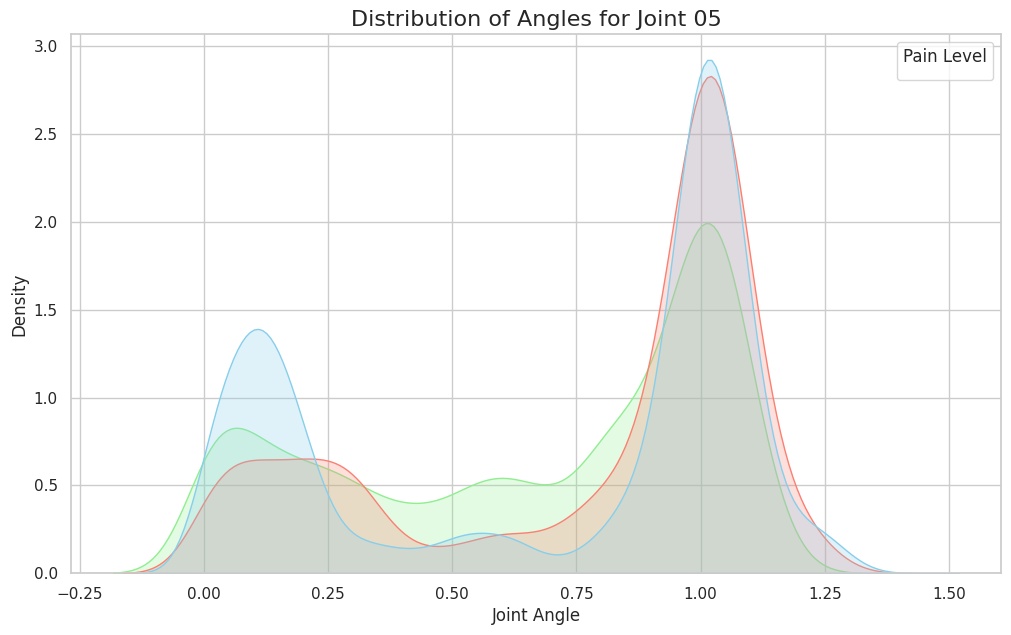

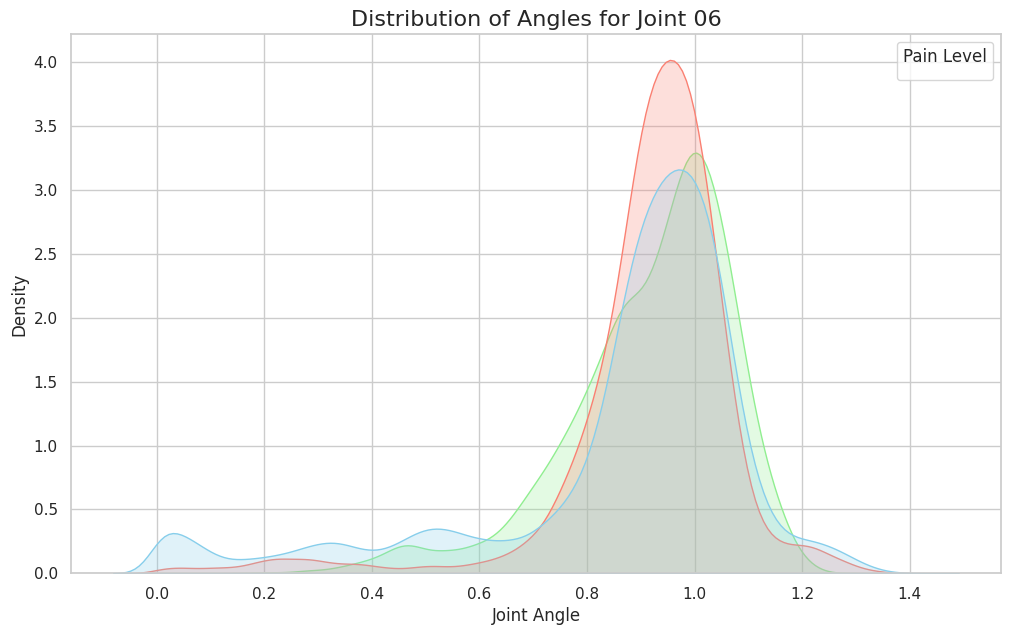

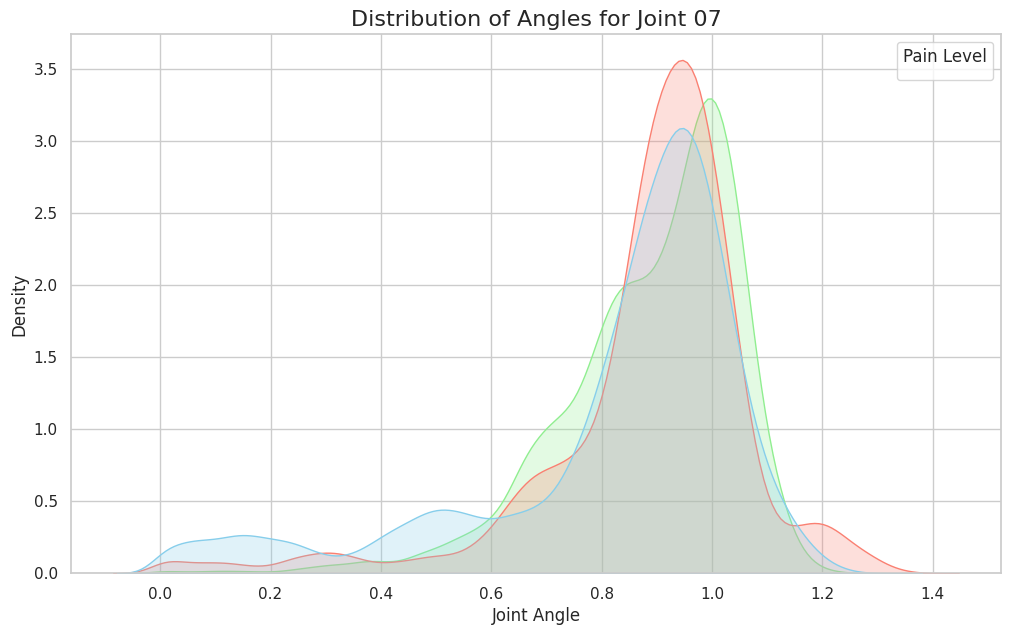

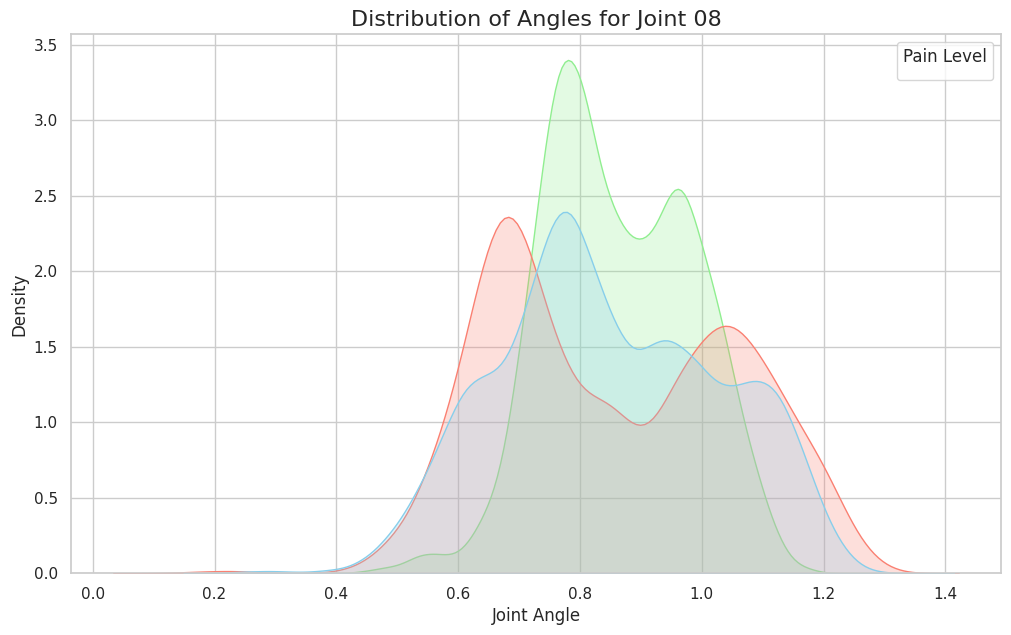

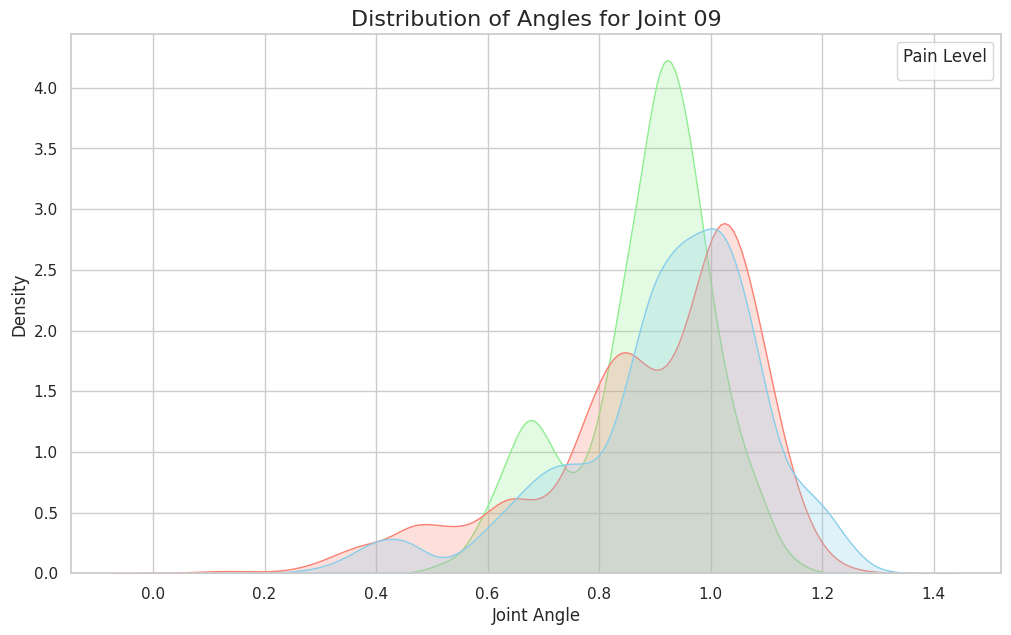

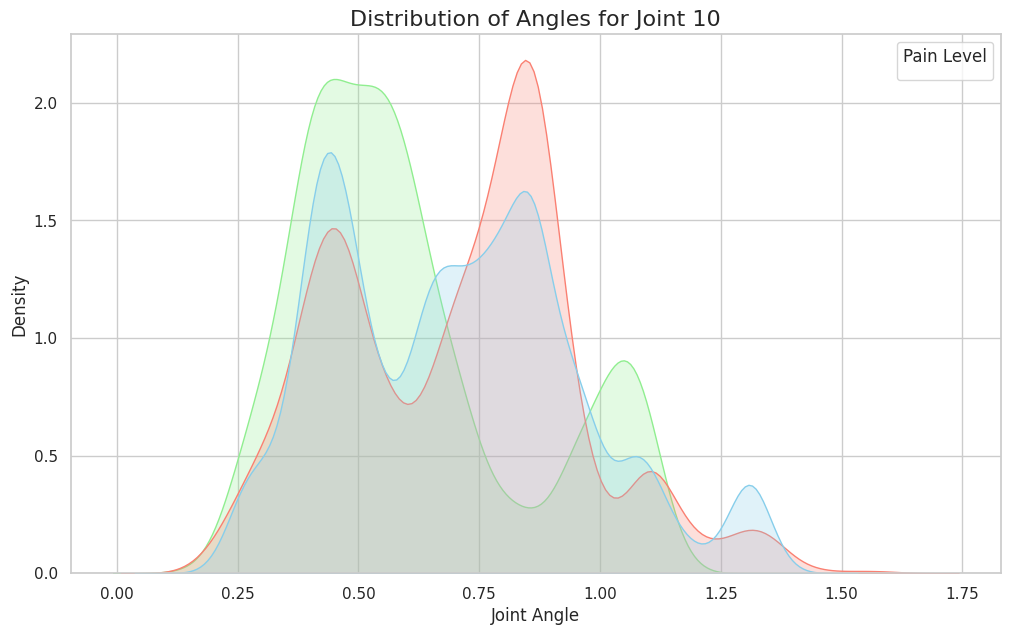

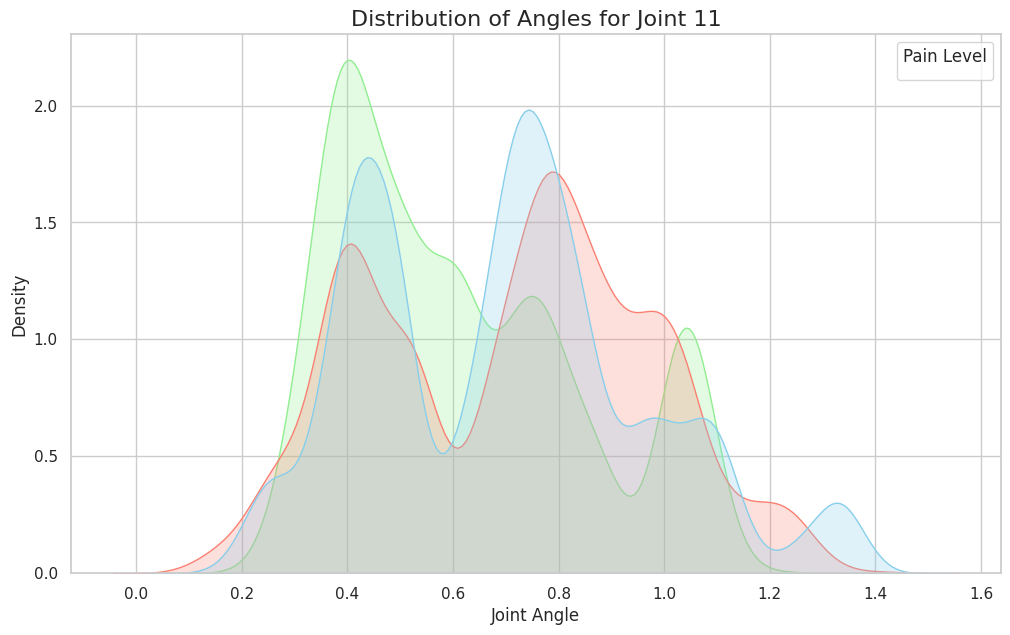

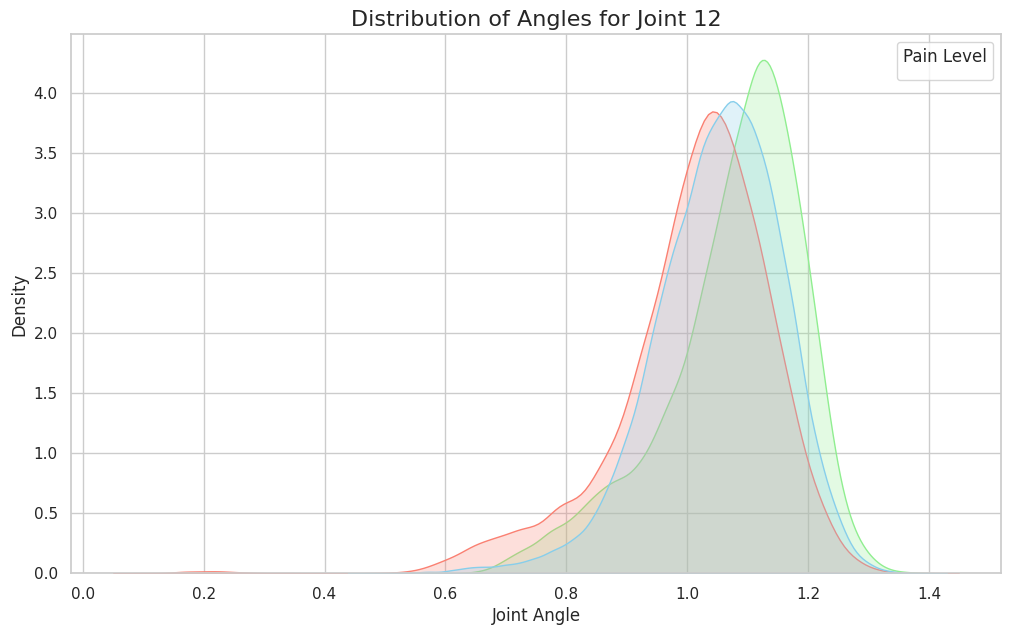

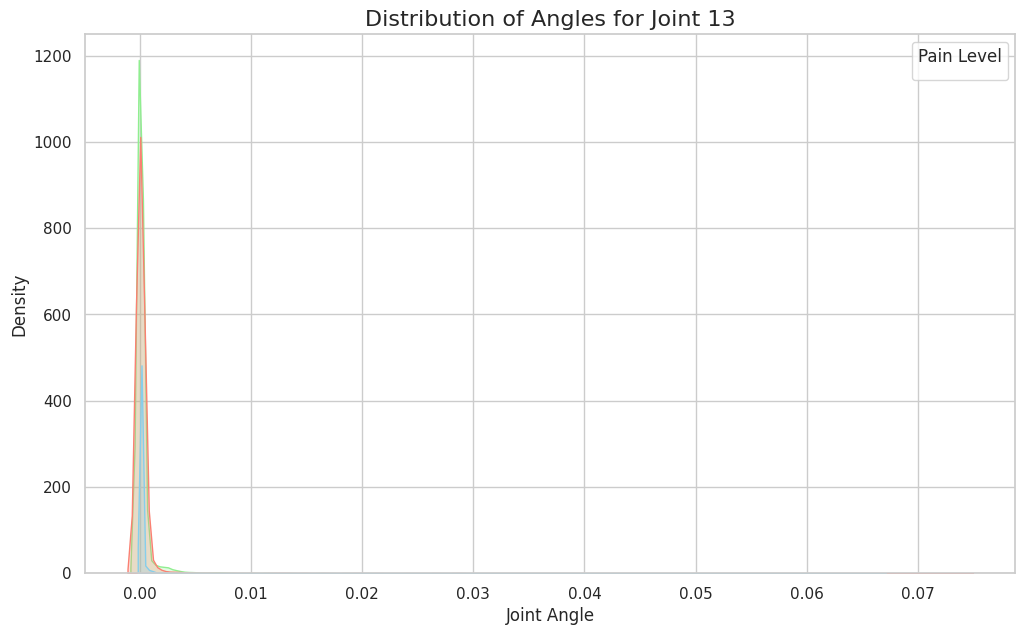

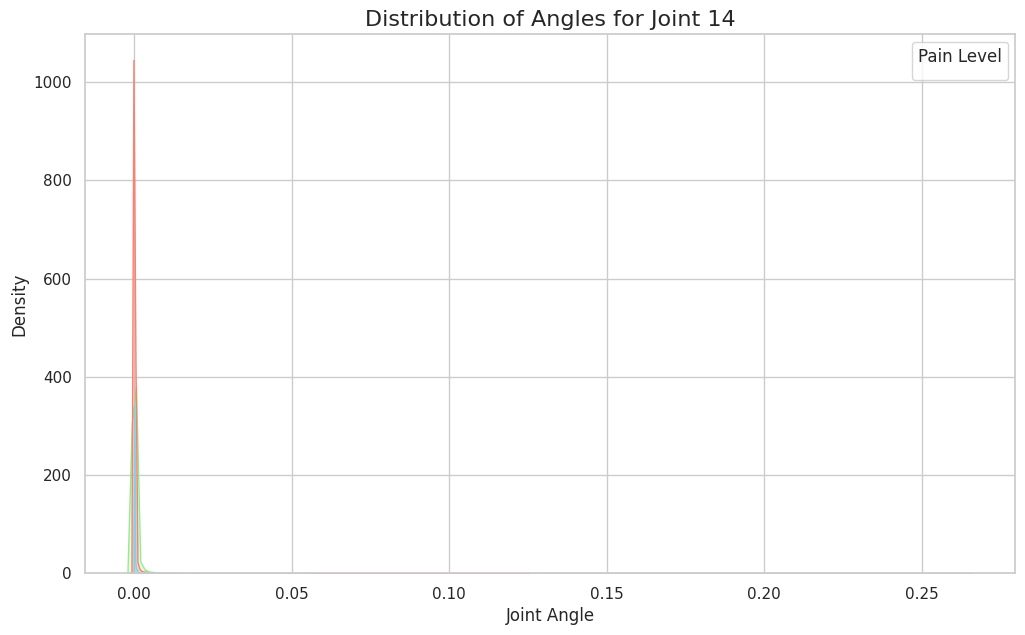

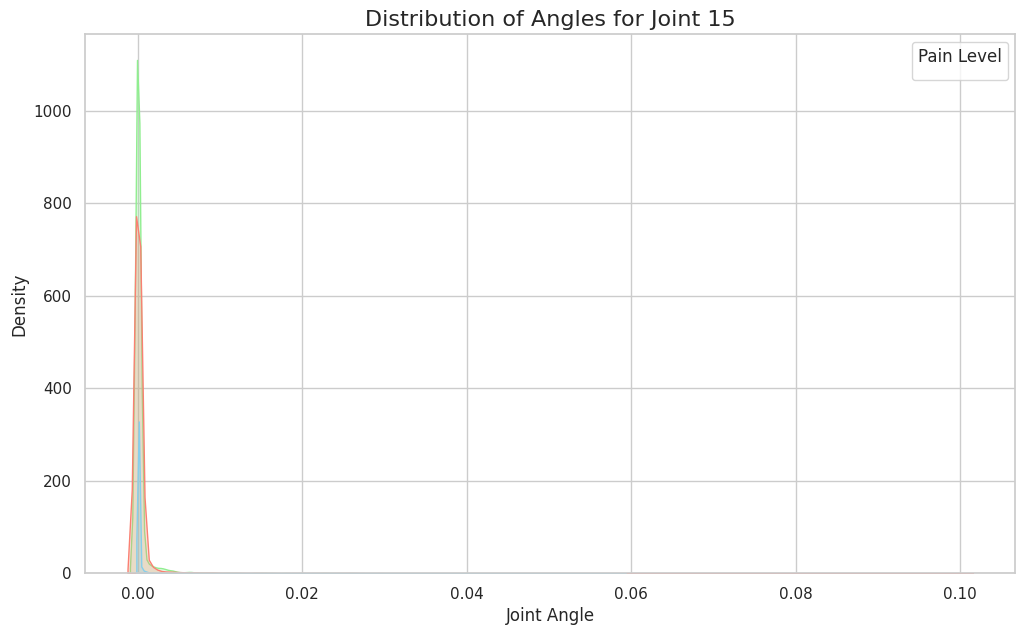

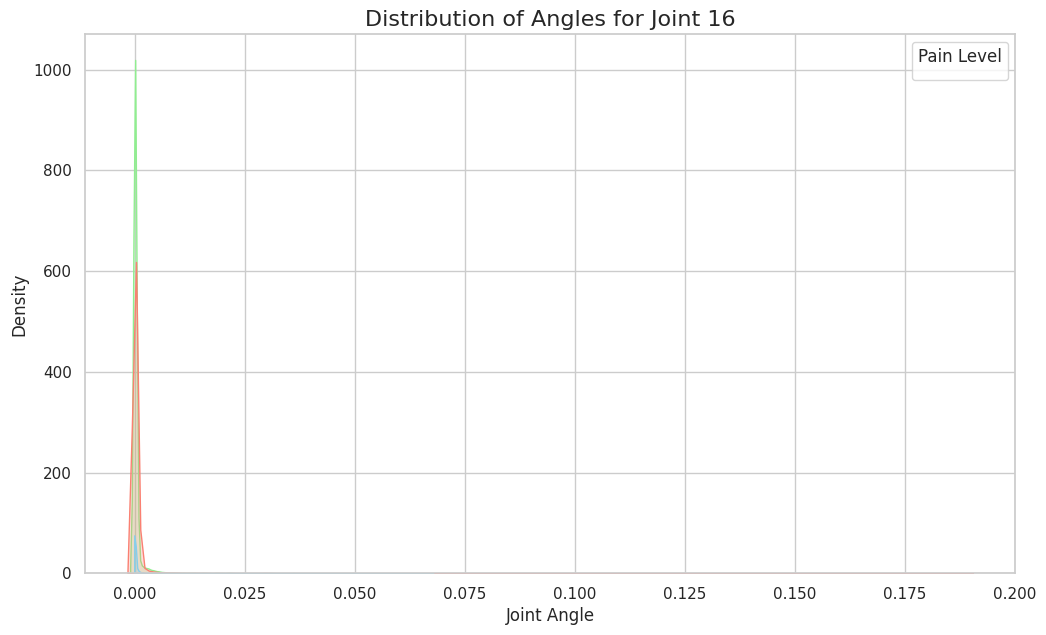

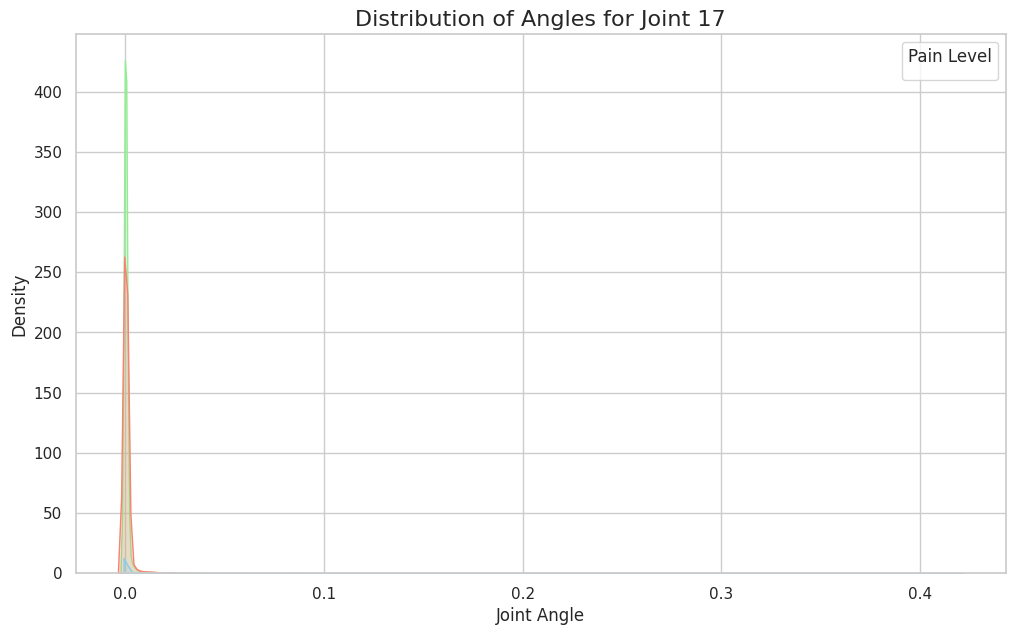

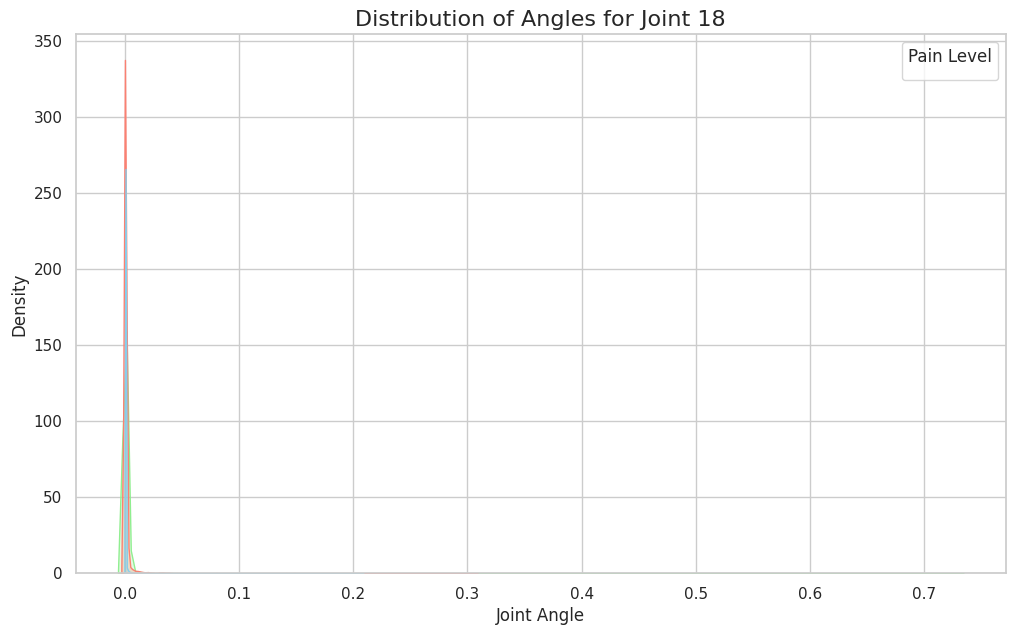

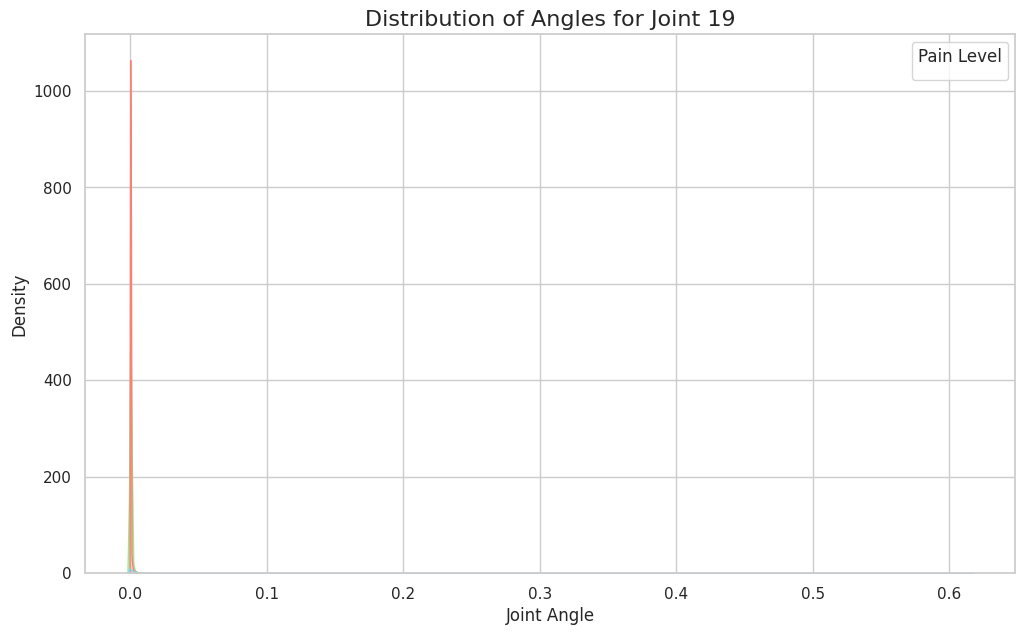

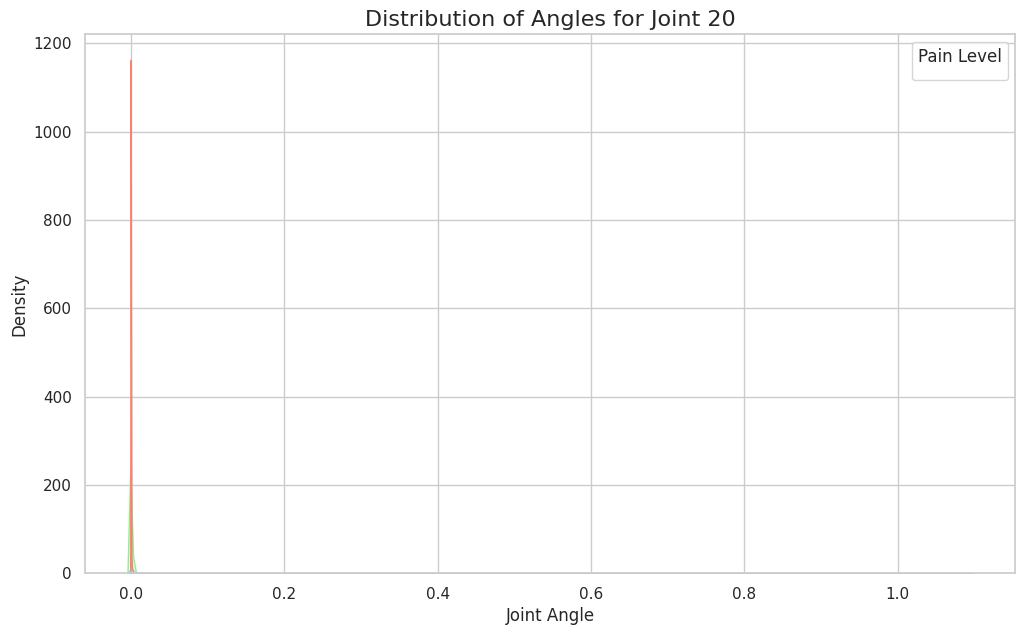

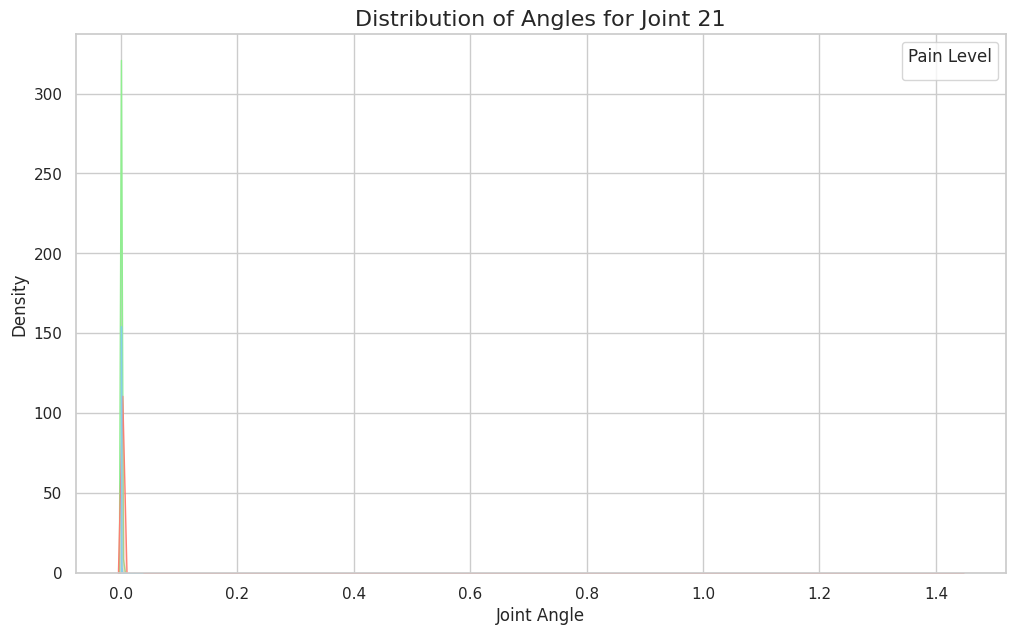

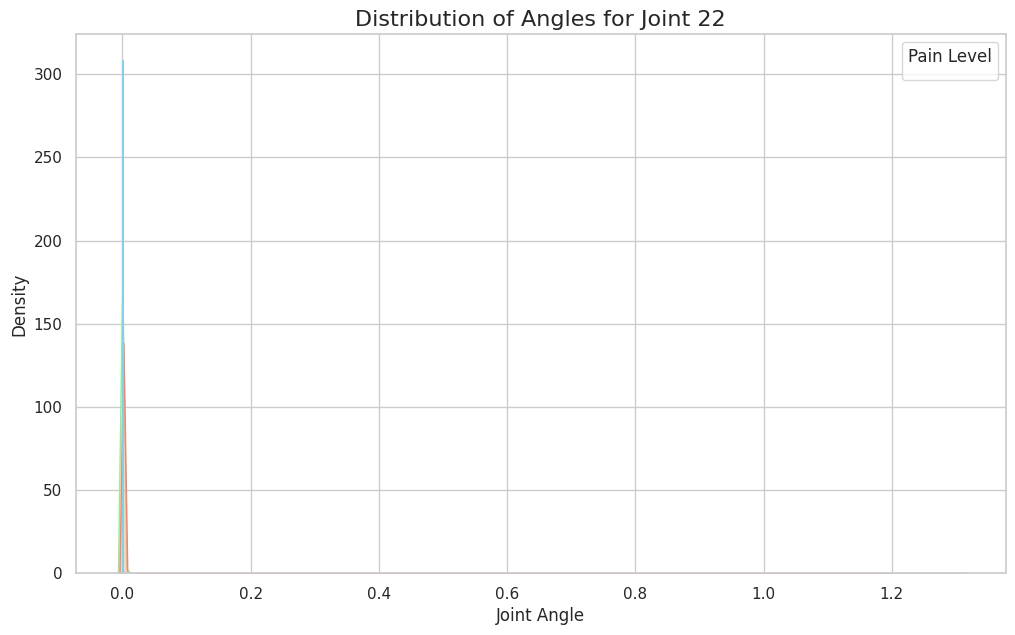

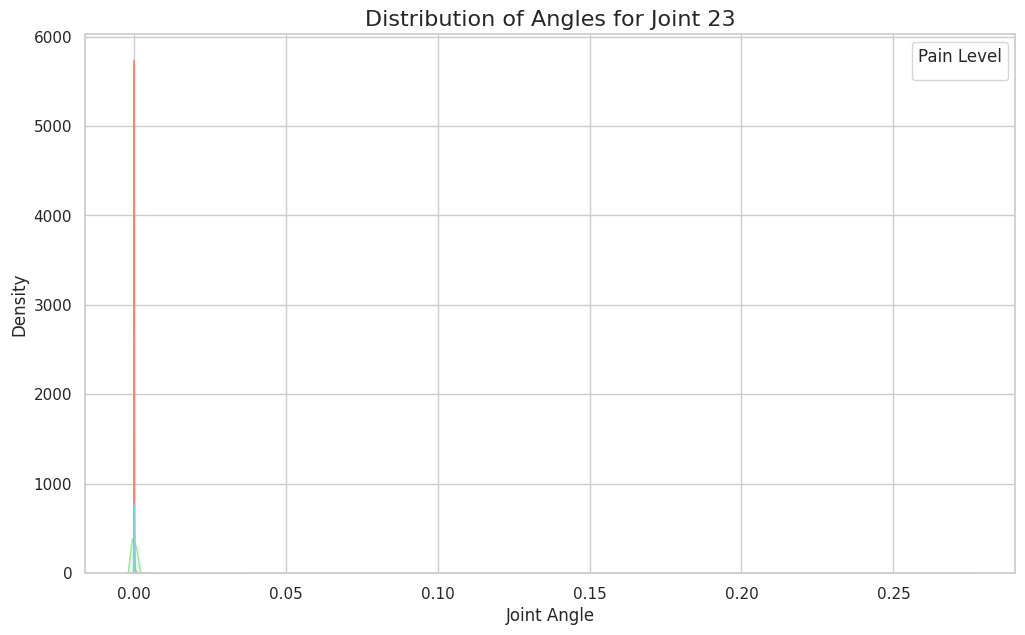

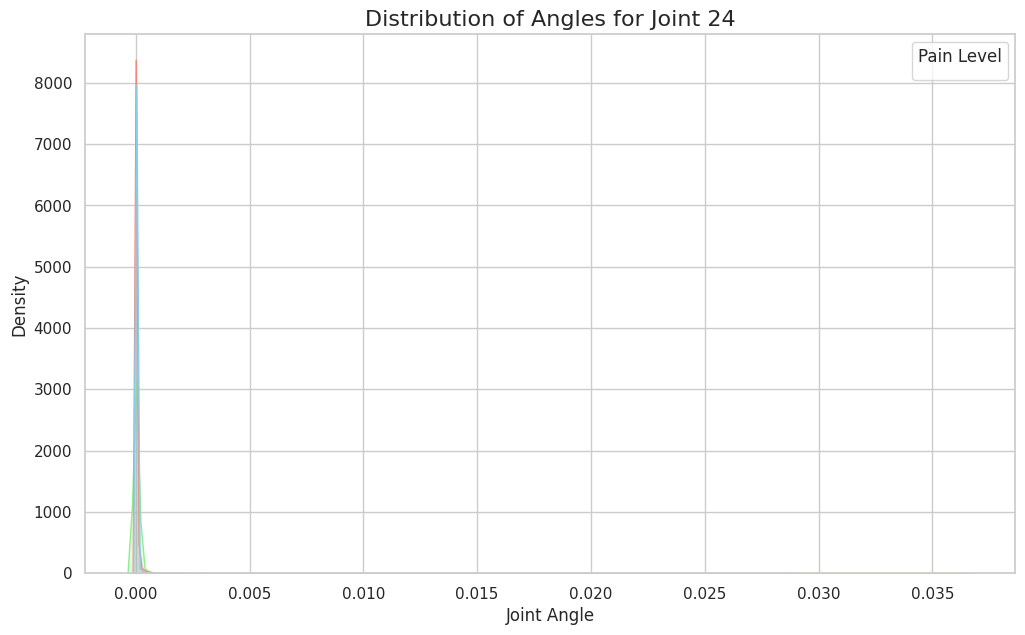

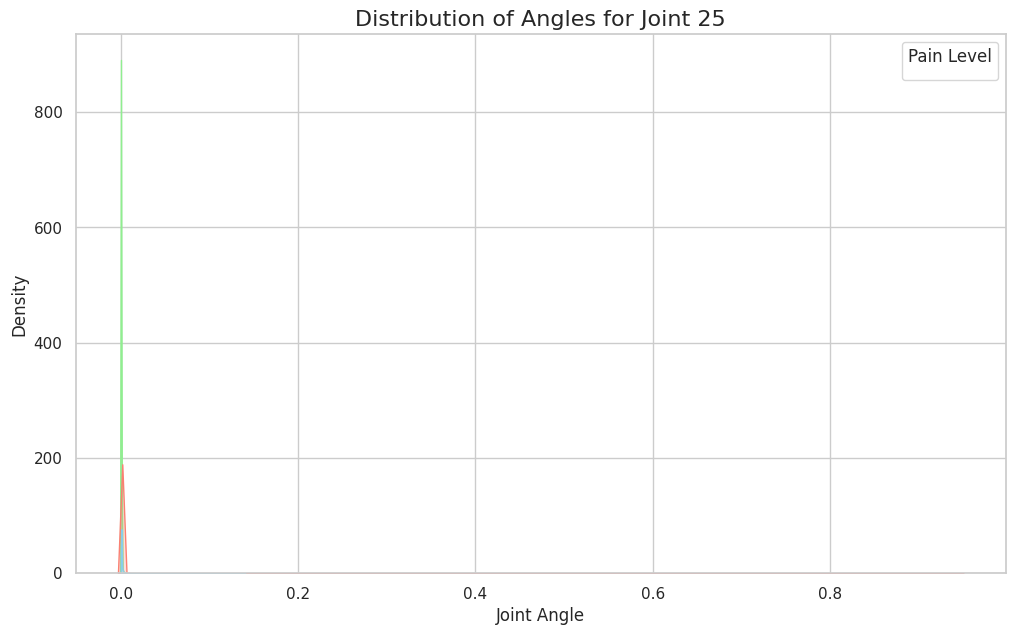

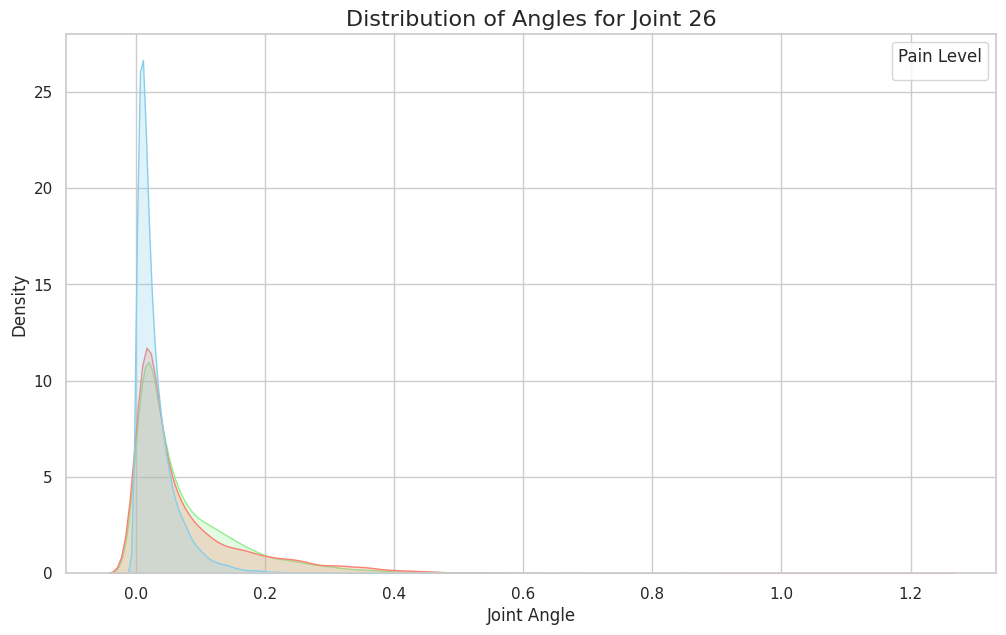

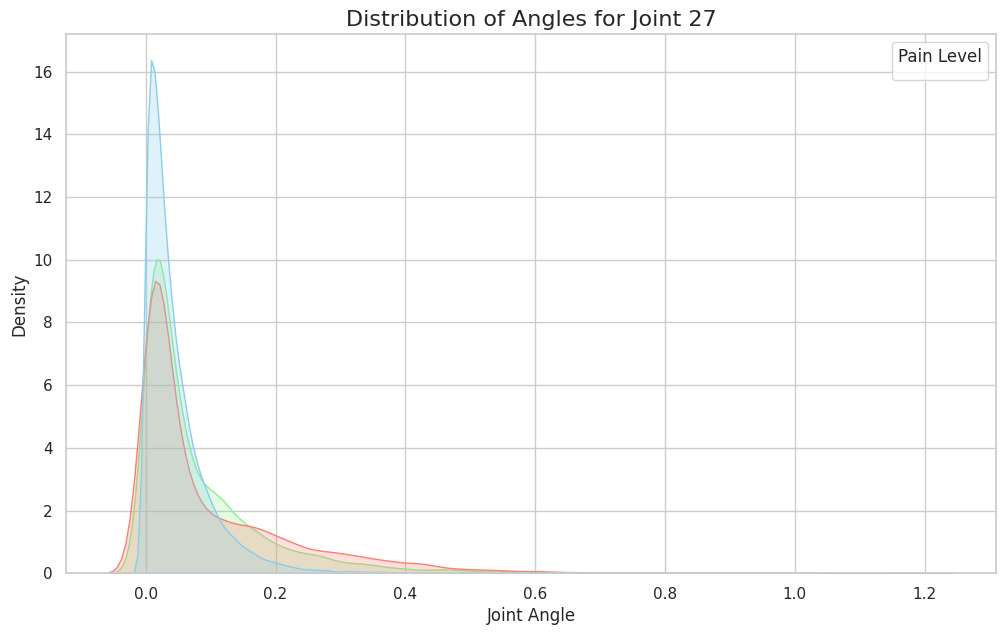

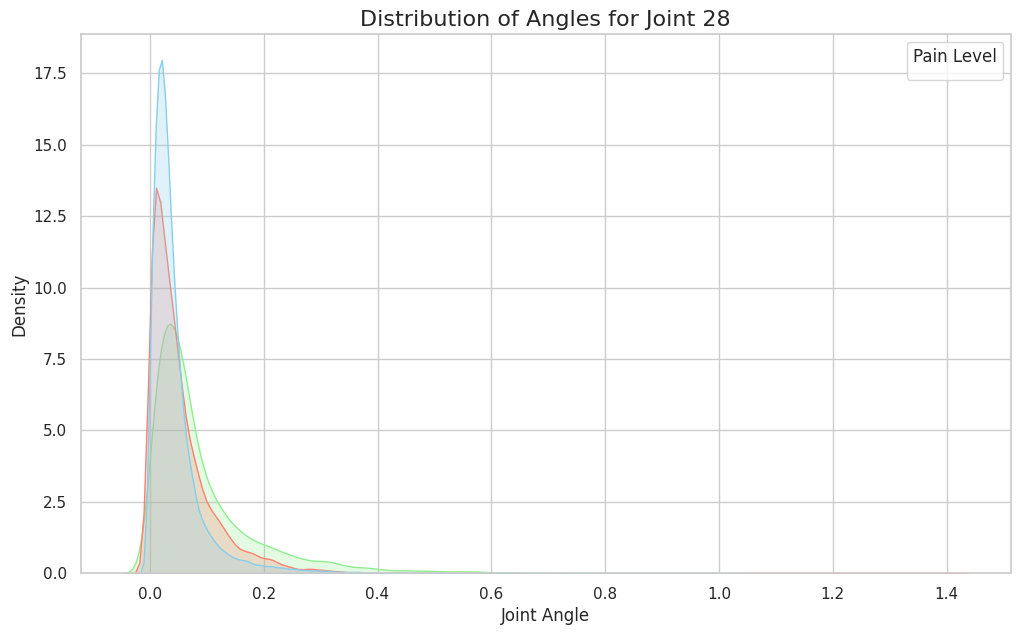

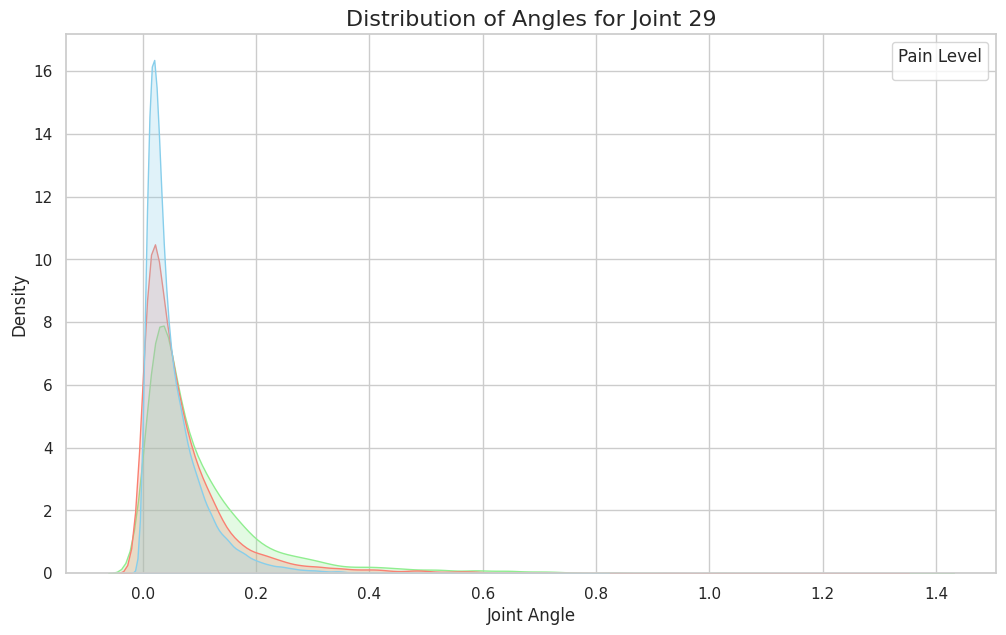

In [ ]:
#PLOTTING JOINTS DISTRIBUTIONS BY LABEL
import seaborn as sns
import matplotlib.pyplot as plt

X_train_original = pd.read_csv("datasets/pirate_pain_train.csv")
y_train_original = pd.read_csv("datasets/pirate_pain_train_labels.csv")
df_for_plotting = pd.merge(X_train_original, y_train_original, on='sample_index')

# Identify the joint columns
joint_columns = [col for col in df_for_plotting.columns if col.startswith('joint')]

# Set up the plot aesthetics
sns.set(style="whitegrid")
palette = {"no_pain": "skyblue", "low_pain": "salmon", "high_pain": "lightgreen"}

print("Displaying distribution plots for the first 6 joints:")
for i in range(0, 30):
    joint = joint_columns[i]
    plt.figure(figsize=(12, 7))
    sns.kdeplot(
        data=df_for_plotting,
        x=joint,
        hue='label',
        palette=palette,
        fill=True,
        common_norm=False)
    plt.title(f'Distribution of Angles for {joint.replace("_", " ").title()}', fontsize=16)
    plt.xlabel('Joint Angle', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(title='Pain Level')
    plt.show()

Displaying NORMALIZED distribution plots for the body part features:


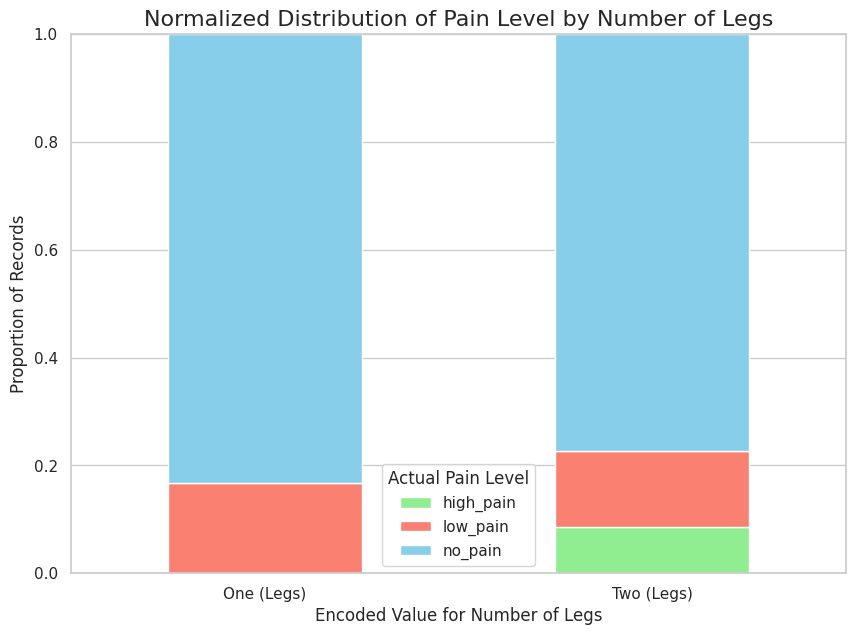

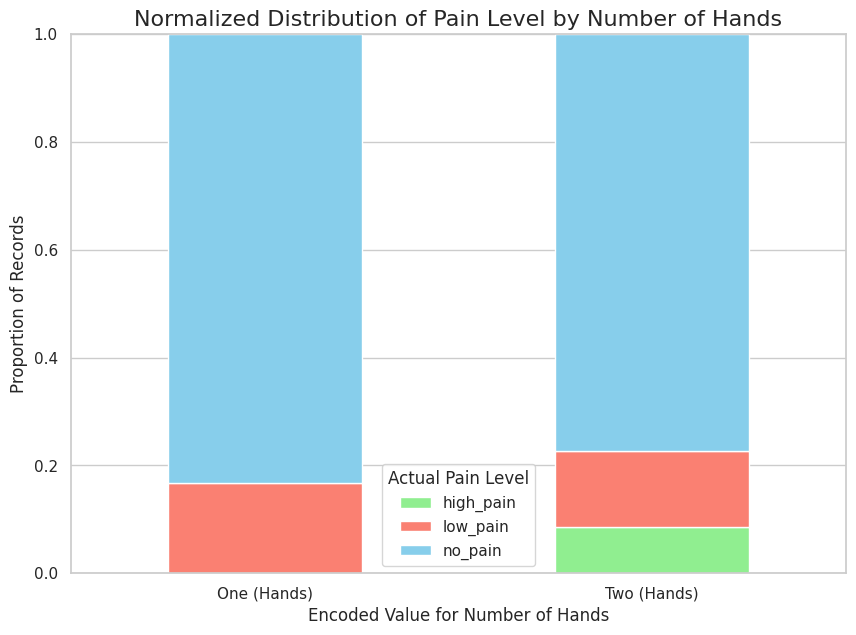

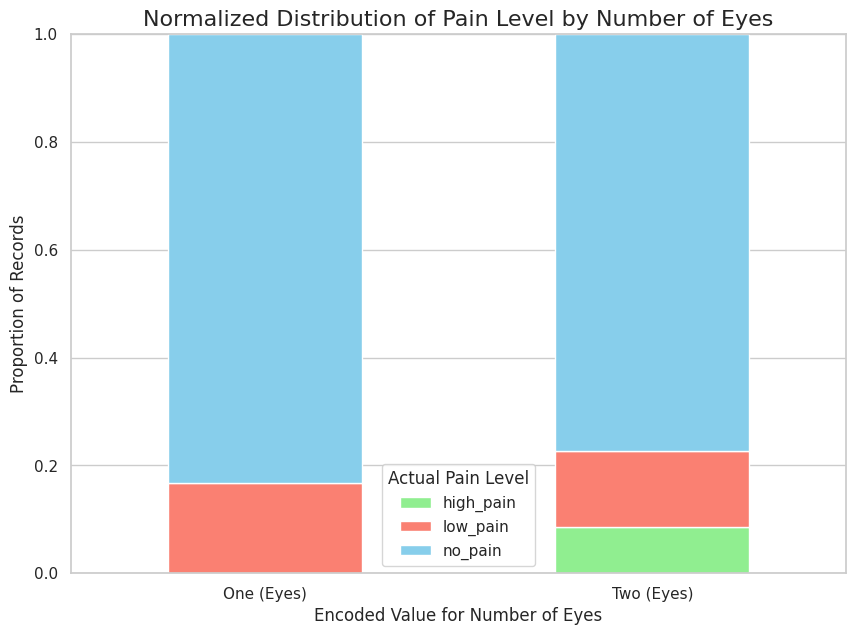

In [ ]:
#PLOTTING BODY PARTS DISTRIBUTIONS BY LABEL
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

X_train_original = pd.read_csv("datasets/pirate_pain_train.csv")
y_train_original = pd.read_csv("datasets/pirate_pain_train_labels.csv")
df_for_plotting = pd.merge(X_train_original, y_train_original, on='sample_index')

df_body_parts_plotting = df_for_plotting.copy()

encoded_cols = ['n_legs_encoded', 'n_hands_encoded', 'n_eyes_encoded']
df_body_parts_plotting[encoded_cols] = X_train[encoded_cols]

sns.set(style="whitegrid")
palette = {"no_pain": "skyblue", "low_pain": "salmon", "high_pain": "lightgreen"}

print("Displaying NORMALIZED distribution plots for the body part features:")
for col in encoded_cols:

    # Group by the encoded feature, get the proportions of the labels, and unstack
    props = df_body_parts_plotting.groupby(col)['label'].value_counts(normalize=True).unstack()

    props.plot(kind='bar', stacked=True, color=[palette[c] for c in props.columns], figsize=(10, 7))

    feature_name = col.replace('_encoded', '').replace('n_', '').replace('_', ' ').title()
    plt.title(f'Normalized Distribution of Pain Level by Number of {feature_name}', fontsize=16)
    plt.xlabel(f'Encoded Value for Number of {feature_name}', fontsize=12)
    plt.ylabel('Proportion of Records', fontsize=12)

    plt.xticks(ticks=[0, 1], labels=[f'One ({feature_name})', f'Two ({feature_name})'], rotation=0)

    plt.legend(title='Actual Pain Level')
    plt.ylim(0, 1)
    plt.show()

In [ ]:
# Study on the pirates who have missing body parts
import pandas as pd

pirate_ids_to_inspect = df_for_plotting[
    (df_for_plotting['n_legs'] == 'one+peg_leg') |
    (df_for_plotting['n_hands'] == 'one+hook_hand') |
    (df_for_plotting['n_eyes'] == 'one+eye_patch')
]['sample_index'].unique()

# Filter the DataFrame to only include these pirates
columns_to_show = ['sample_index', 'n_legs', 'n_hands', 'n_eyes', 'label']
df_subset = df_for_plotting[df_for_plotting['sample_index'].isin(pirate_ids_to_inspect)][columns_to_show]


# leaving one representative row per pirate.
df_summary = df_subset.drop_duplicates(subset=['sample_index']).set_index('sample_index')

print(f"Found {len(df_summary)} unique pirates with at least one 'one' body part.")
print("Displaying a summary of their body parts and pain levels:")

display(df_summary)

Found 6 unique pirates with at least one 'one' body part.
Displaying a summary of their body parts and pain levels:


n_legs        n_hands         n_eyes     label
sample_index                                                     
8             one+peg_leg  one+hook_hand  one+eye_patch   no_pain
137           one+peg_leg  one+hook_hand  one+eye_patch   no_pain
216           one+peg_leg  one+hook_hand  one+eye_patch   no_pain
338           one+peg_leg  one+hook_hand  one+eye_patch  low_pain
350           one+peg_leg  one+hook_hand  one+eye_patch   no_pain
496           one+peg_leg  one+hook_hand  one+eye_patch   no_pain

# Plotting all joints for a sample

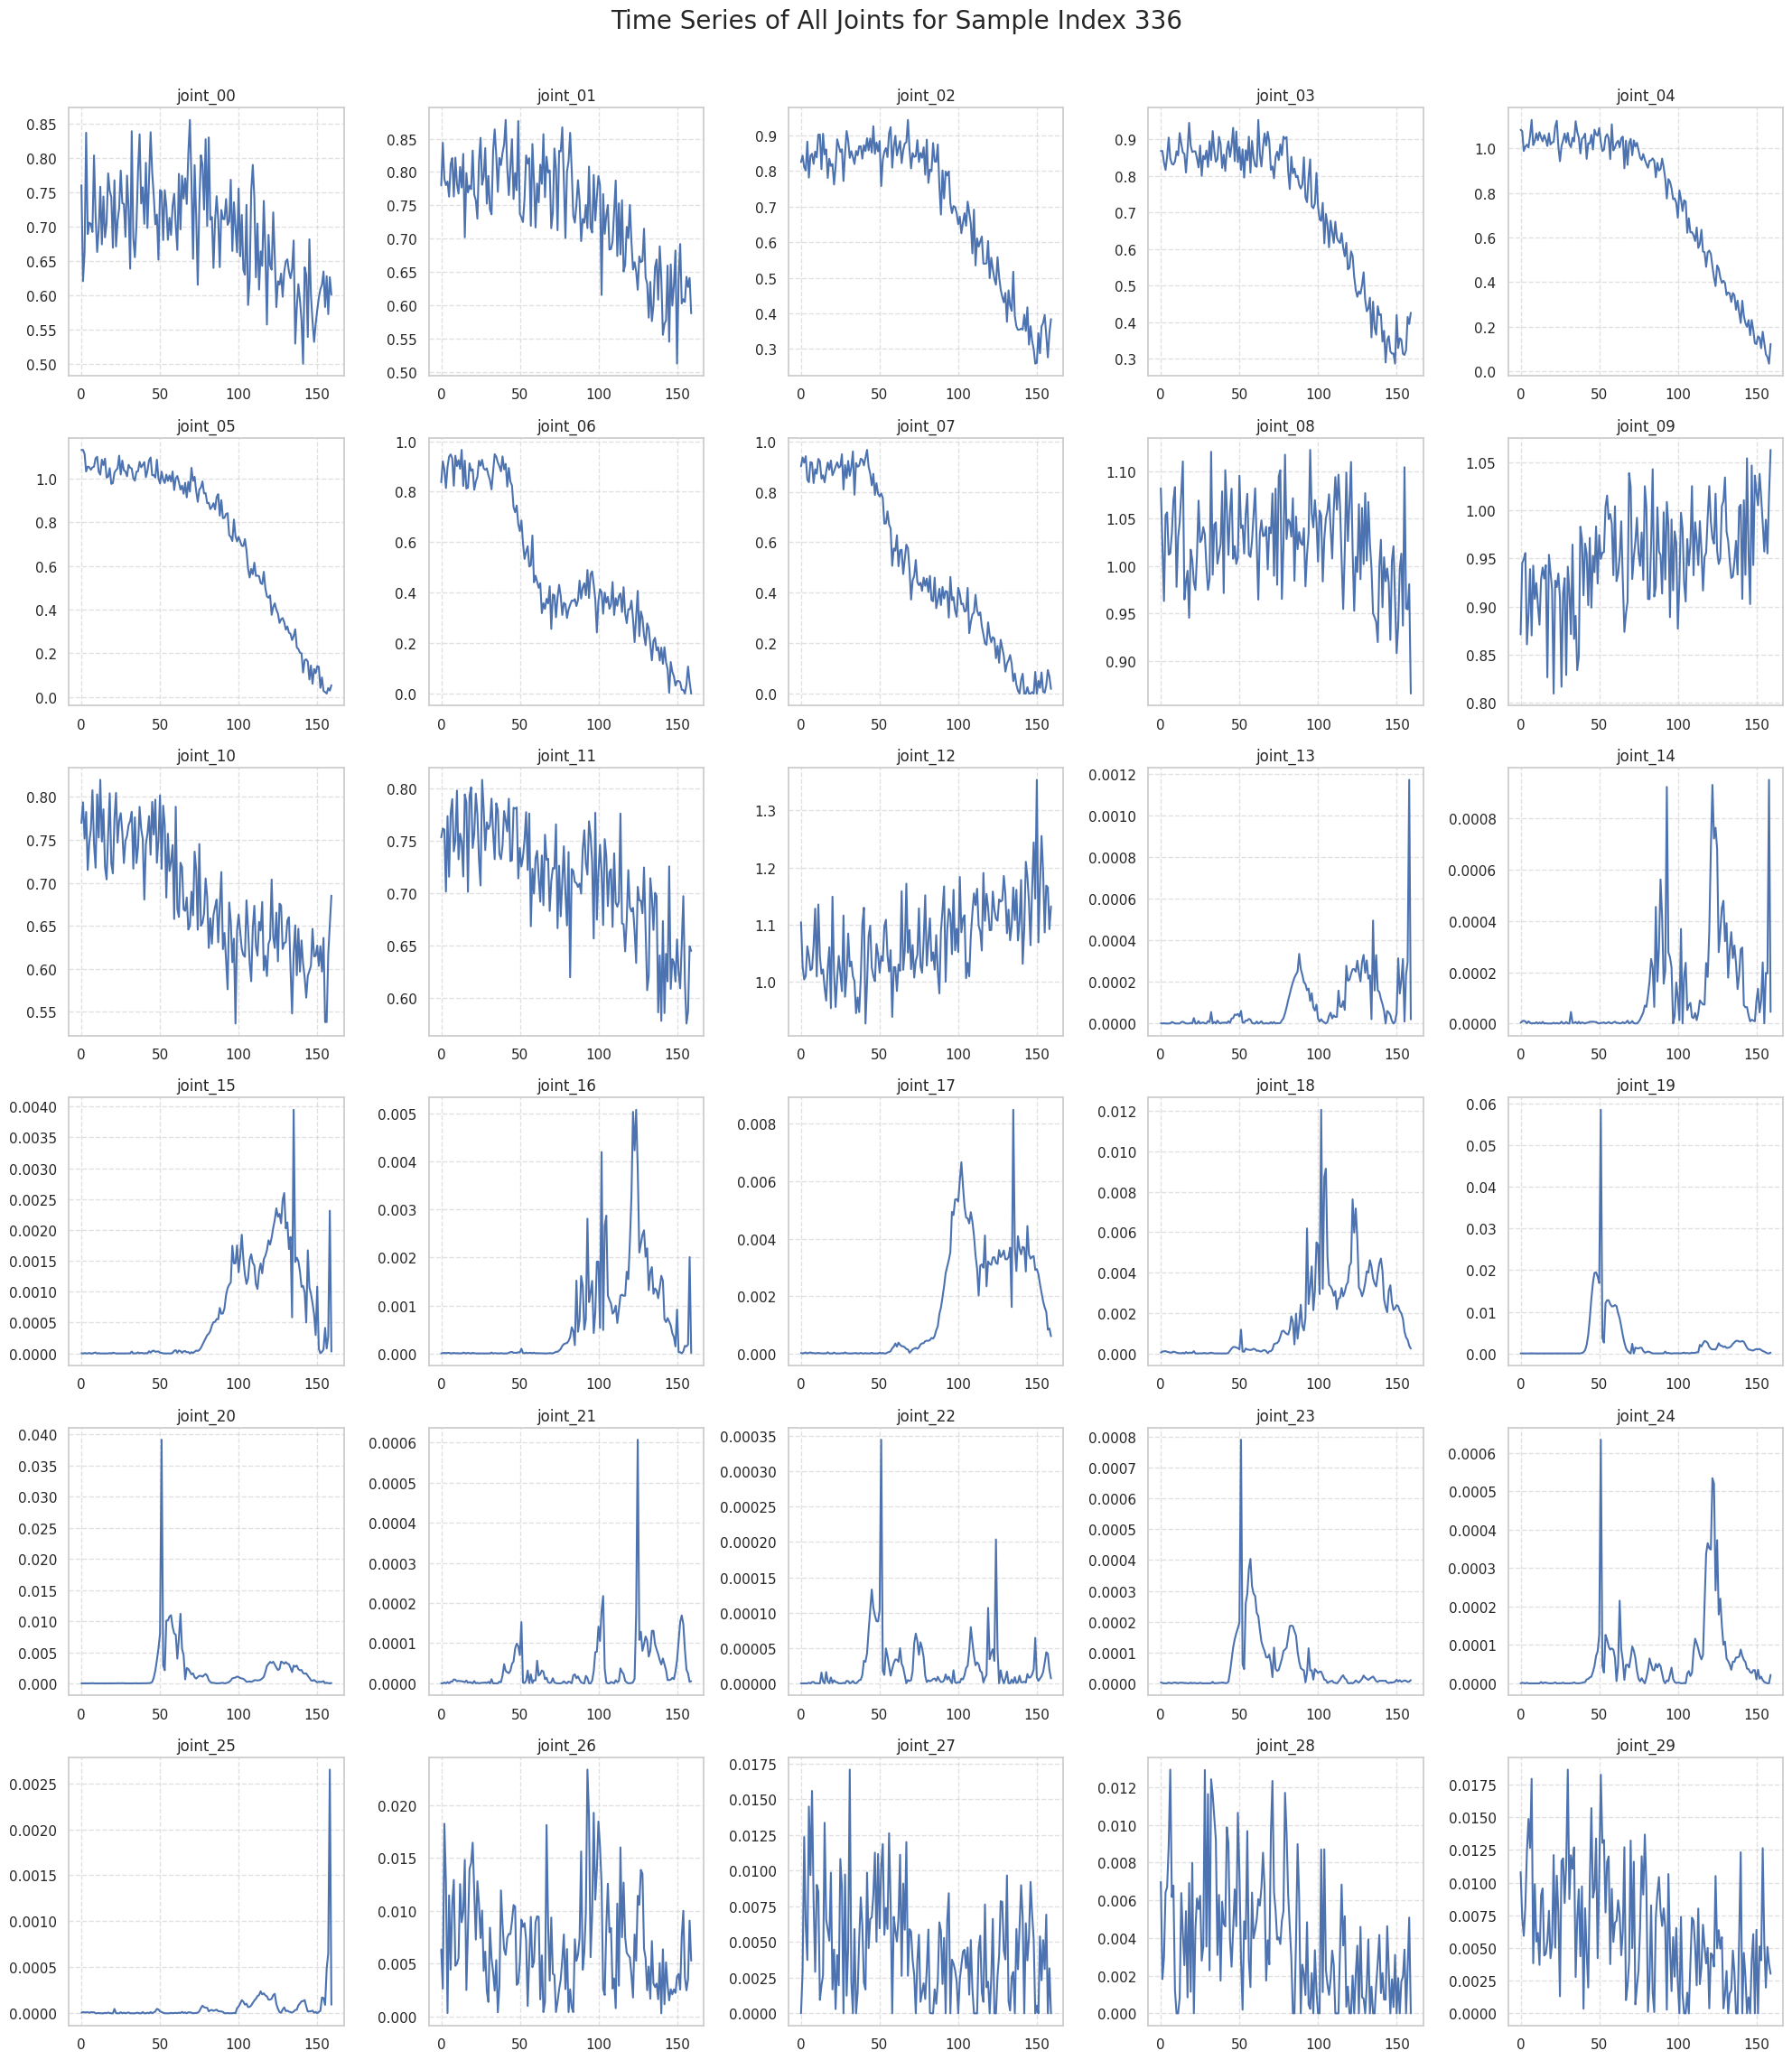

In [ ]:


# Isolate the data for one sample
sample_to_plot = 336 #LOW PAIN
sample_df = df[df['sample_index'] == sample_to_plot].copy()

joint_columns = [col for col in df.columns if 'joint_' in col]
num_joints = len(joint_columns)

nrows = 6
ncols = 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 24))

fig.suptitle(f'Time Series of All Joints for Sample Index {sample_to_plot}', fontsize=20)


# Iterate and plot each joint
for ax, joint_name in zip(axes.flatten(), joint_columns):
    # Plot the data for the current joint
    ax.plot(sample_df['time'], sample_df[joint_name])
    ax.set_title(joint_name)
    ax.grid(True, linestyle='--', alpha=0.6)

for i in range(num_joints, nrows * ncols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.97])

plt.show()

# Plotting average patterns for class

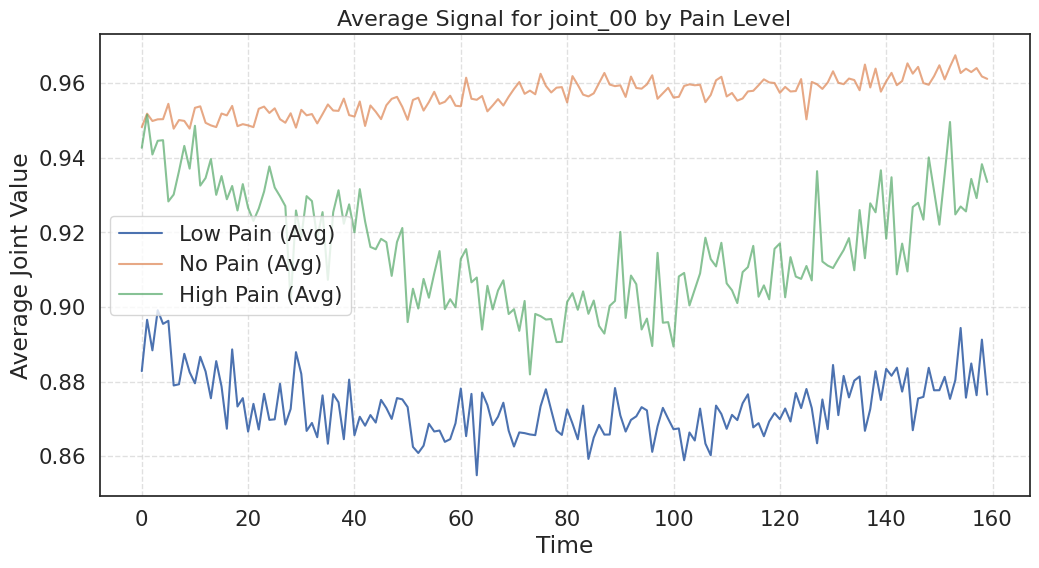

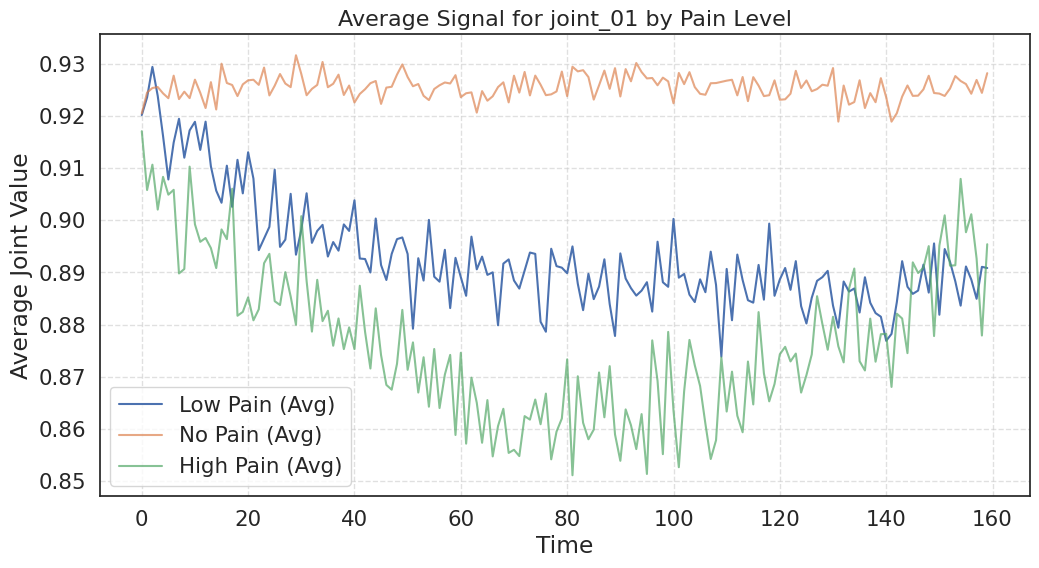

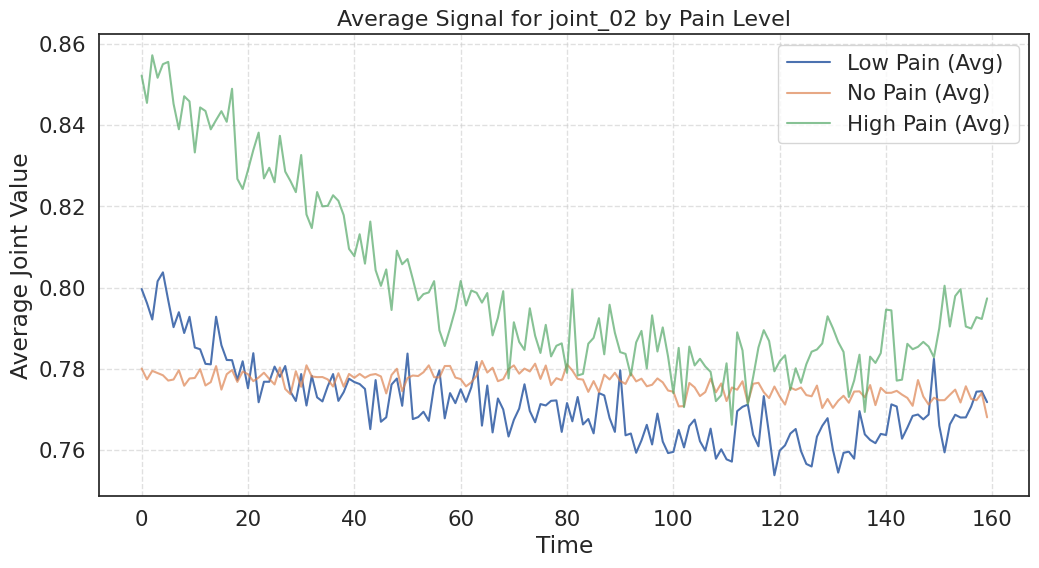

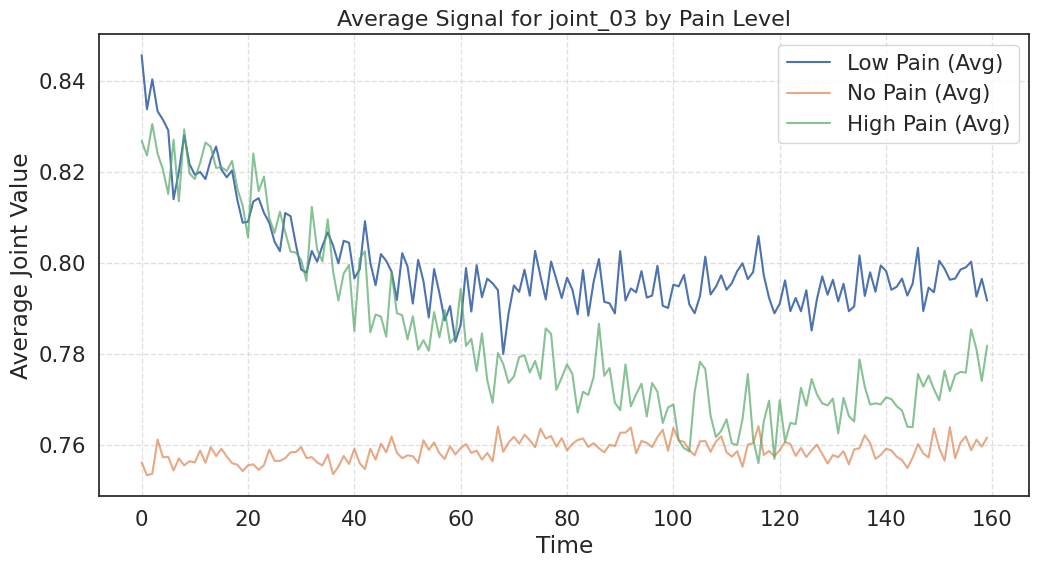

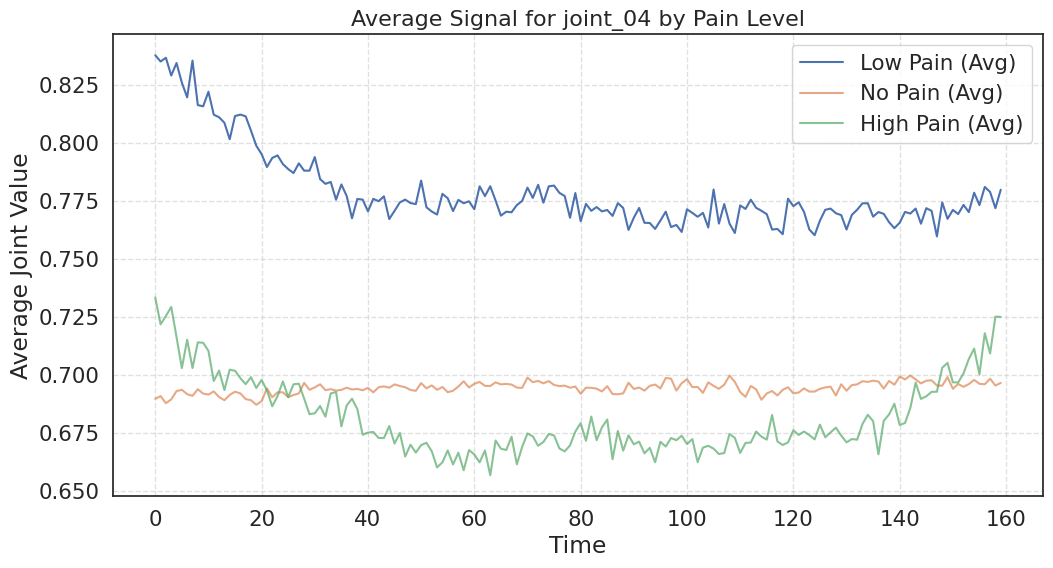

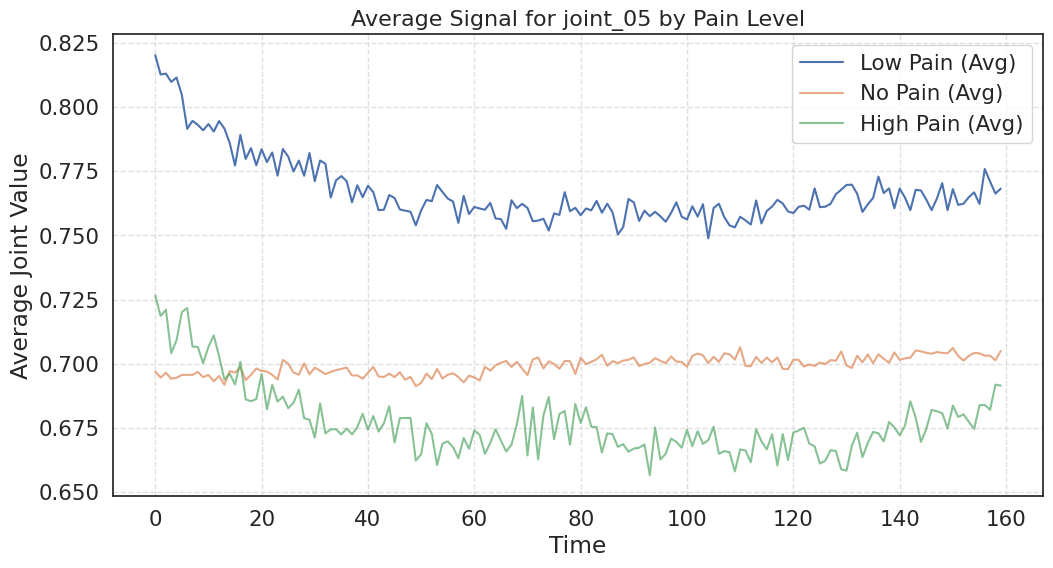

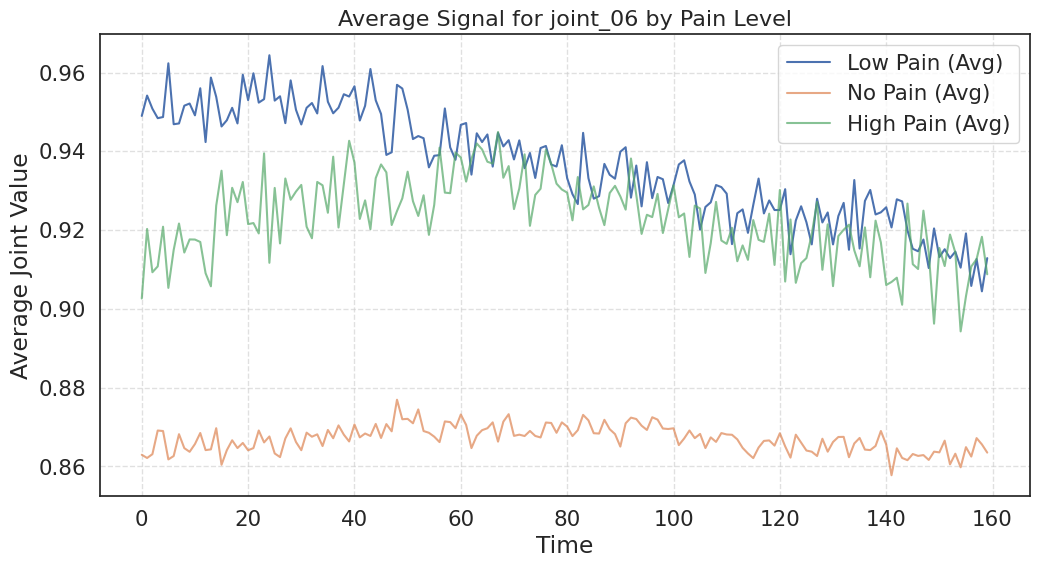

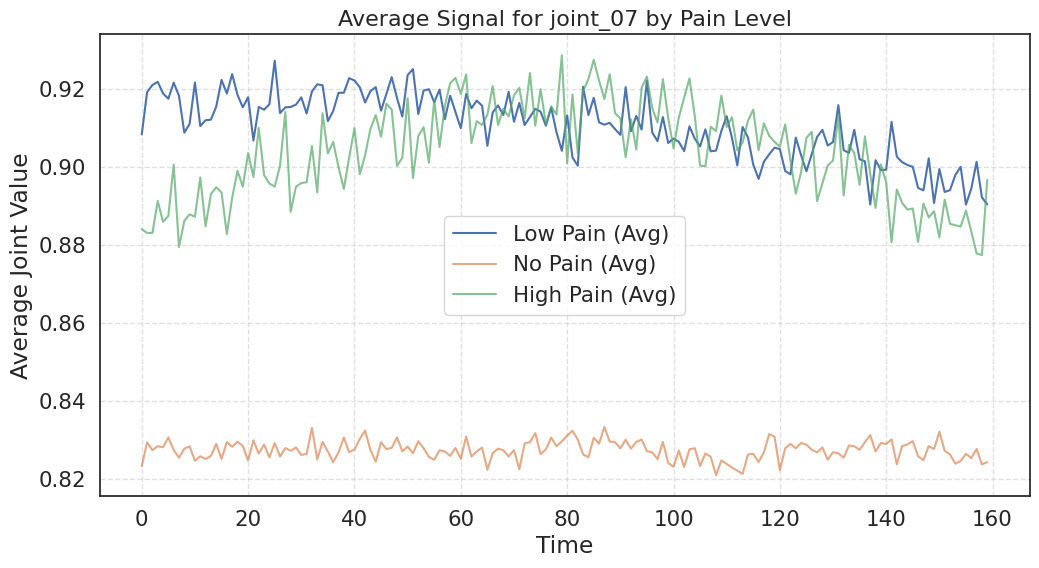

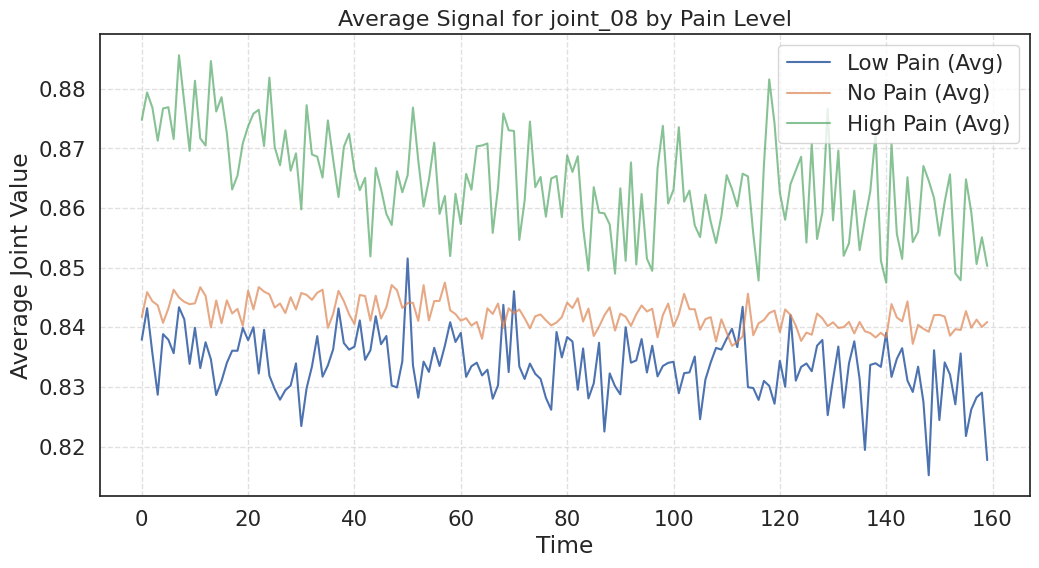

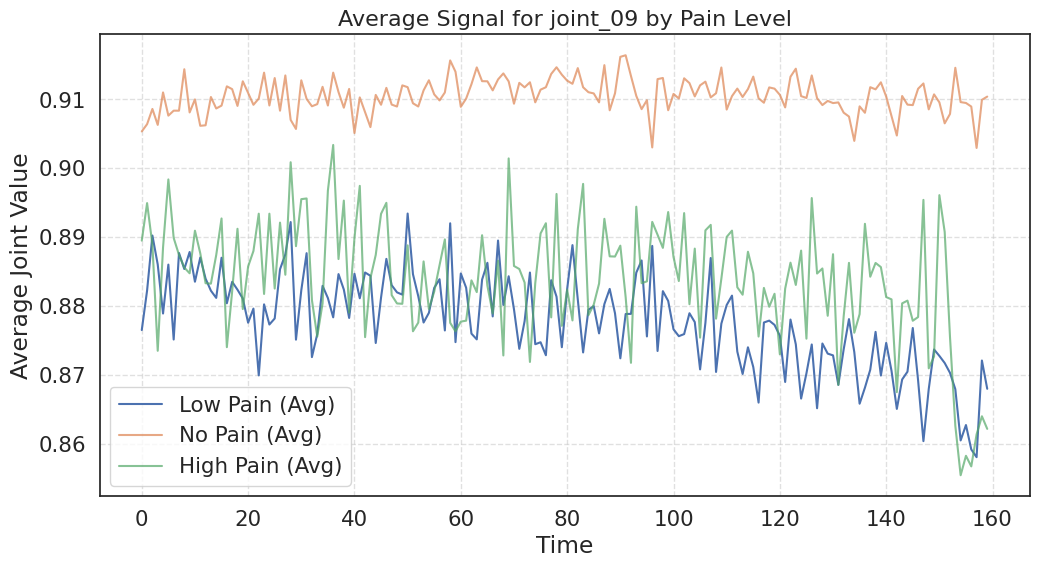

In [ ]:
joints_to_plot = [f'joint_0{i}' for i in range(0, 10)]

for joint_name in joints_to_plot:
    plt.figure(figsize=(12, 6))

    # Plot the average time series for each pain level
    plt.plot(low_pain_avg.index, low_pain_avg[joint_name], label='Low Pain (Avg)')
    plt.plot(no_pain_avg.index, no_pain_avg[joint_name], label='No Pain (Avg)', alpha=0.7)
    plt.plot(high_pain_avg.index, high_pain_avg[joint_name], label='High Pain (Avg)', alpha=0.7)

    plt.title(f'Average Signal for {joint_name} by Pain Level', fontsize=16)
    plt.xlabel('Time')
    plt.ylabel('Average Joint Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

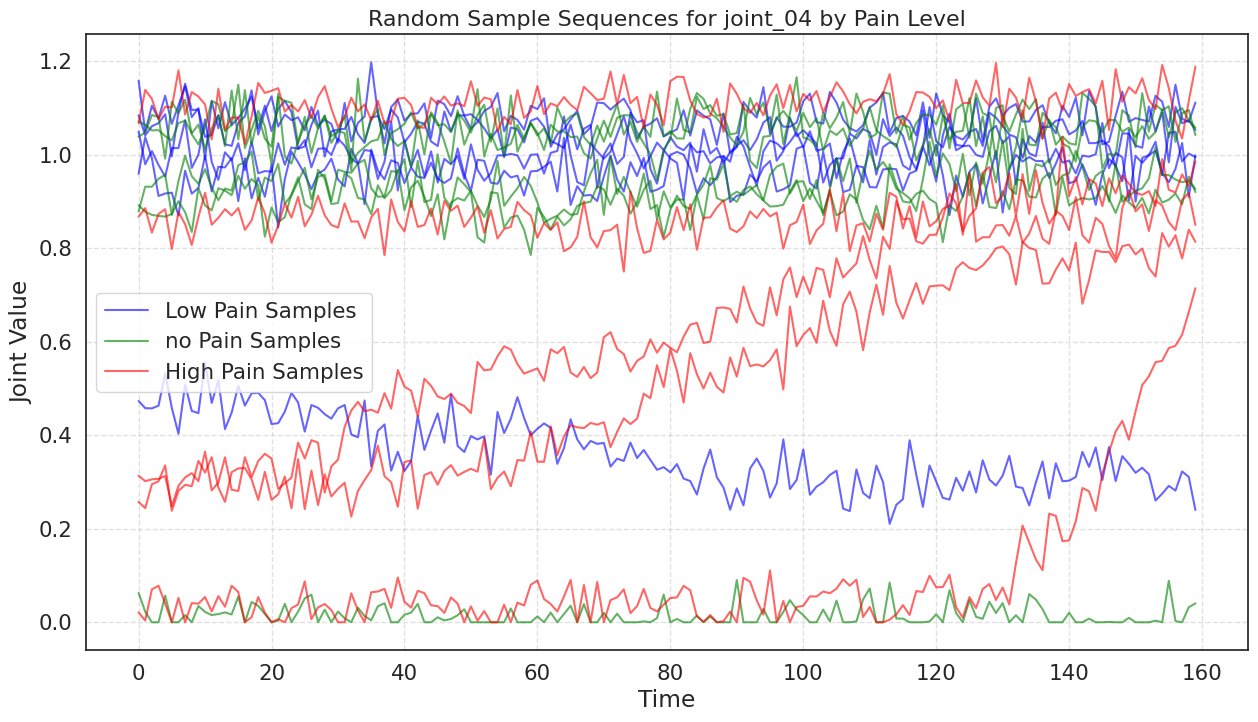

In [ ]:
import random

joint_to_plot = 'joint_04'

num_samples_to_plot = 5

low_pain_samples = low_pain_df['sample_index'].unique()
no_pain_samples = no_pain_df['sample_index'].unique()
high_pain_samples = high_pain_df['sample_index'].unique()

random_low_samples = random.sample(list(low_pain_samples), min(num_samples_to_plot, len(low_pain_samples)))
random_no_pain_samples = random.sample(list(no_pain_samples), min(num_samples_to_plot, len(no_pain_samples)))
random_high_samples = random.sample(list(high_pain_samples), min(num_samples_to_plot, len(high_pain_samples)))

plt.figure(figsize=(15, 8))

def plot_random_samples(df, sample_indices, joint_name, color, label):
    first_sample_id = sample_indices[0]
    sample_df = df[df['sample_index'] == first_sample_id]
    plt.plot(sample_df['time'], sample_df[joint_name], color=color, alpha=0.6, label=label)

    for sample_id in sample_indices[1:]:
        sample_df = df[df['sample_index'] == sample_id]
        plt.plot(sample_df['time'], sample_df[joint_name], color=color, alpha=0.6)

# Plot for each category
plot_random_samples(low_pain_df, random_low_samples, joint_to_plot, 'blue', 'Low Pain Samples')
plot_random_samples(no_pain_df, random_no_pain_samples, joint_to_plot, 'green', 'no Pain Samples')
plot_random_samples(high_pain_df, random_high_samples, joint_to_plot, 'red', 'High Pain Samples')

plt.title(f'Random Sample Sequences for {joint_to_plot} by Pain Level', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Joint Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Feature engineering

Substitution of columns from 13 to 25 with their std var and max for each sequence

In [ ]:
X_train_original = pd.read_csv("datasets/pirate_pain_train.csv")
y_train_original = pd.read_csv("datasets/pirate_pain_train_labels.csv")
df_for_eng = pd.merge(X_train_original, y_train_original, on='sample_index')

joint_columns_subset = [f"joint_{i}" for i in range(13, 26)]
print(f"Selecting joints: {joint_columns_subset}")

aggregations = {joint: ['std', 'max'] for joint in joint_columns_subset}
engineered_features_df = df_for_eng.groupby('sample_index').agg(aggregations)

engineered_features_df.columns = ['_'.join(col).strip() for col in engineered_features_df.columns.values]

y_train_original = pd.read_csv("datasets/pirate_pain_train_labels.csv")
final_df = pd.merge(engineered_features_df, y_train_original, on='sample_index')

print("\nEngineered features for joints 13-25 created. Here's a preview:")
final_df.head()

Selecting joints: ['joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25']

Engineered features for joints 13-25 created. Here's a preview:


sample_index  joint_13_std  joint_13_max  joint_14_std  joint_14_max  \
0             0      0.000006      0.000048      0.000004      0.000033   
1             1      0.000003      0.000012      0.000002      0.000010   
2             2      0.000592      0.007273      0.000320      0.003933   
3             3      0.000003      0.000012      0.000002      0.000011   
4             4      0.000003      0.000013      0.000002      0.000010   

   joint_15_std  joint_15_max  joint_16_std  joint_16_max  joint_17_std  ...  \
0      0.000007      0.000053      0.000002      0.000011      0.000010  ...   
1      0.000003      0.000015      0.000003      0.000015      0.000011  ...   
2      0.000845      0.010418      0.000051      0.000610      0.000016  ...   
3      0.000003      0.000013      0.000003      0.000016      0.000012  ...   
4      0.000003      0.000010      0.000003      0.000012      0.000012  ...   

   joint_21_max  joint_22_std  joint_22_max  joint_23_std  joint_23_max  \
0      0.001322  1.015094e-05      0.000110      0.000006      0.000044   
1      0.000005  9.512200e-07      0.000004      0.000001      0.000005   
2      0.000030  2.737193e-05      0.000340      0.000083      0.001031   
3      0.000007  1.141577e-06      0.000006      0.000001      0.000006   
4      0.000005  1.339204e-06      0.000011      0.000001      0.000006   

   joint_24_std  joint_24_max  joint_25_std  joint_25_max     label  
0  6.376393e-06      0.000054      0.000037      0.000397   no_pain  
1  8.905525e-07      0.000006      0.000003      0.000016   no_pain  
2  4.462460e-05      0.000540      0.000129      0.001580  low_pain  
3  8.881321e-07      0.000005      0.000010      0.000072   no_pain  
4  1.470244e-06      0.000012      0.000003      0.000012   no_pain  

[5 rows x 28 columns]

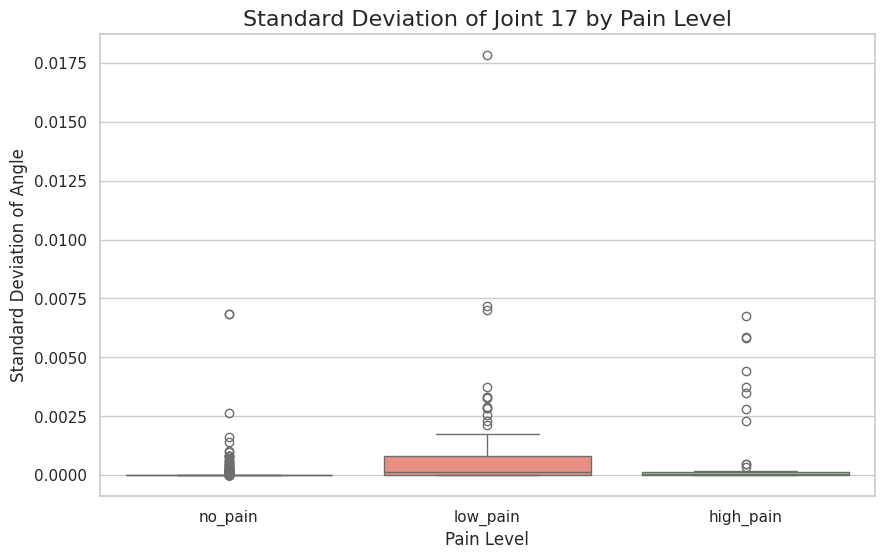

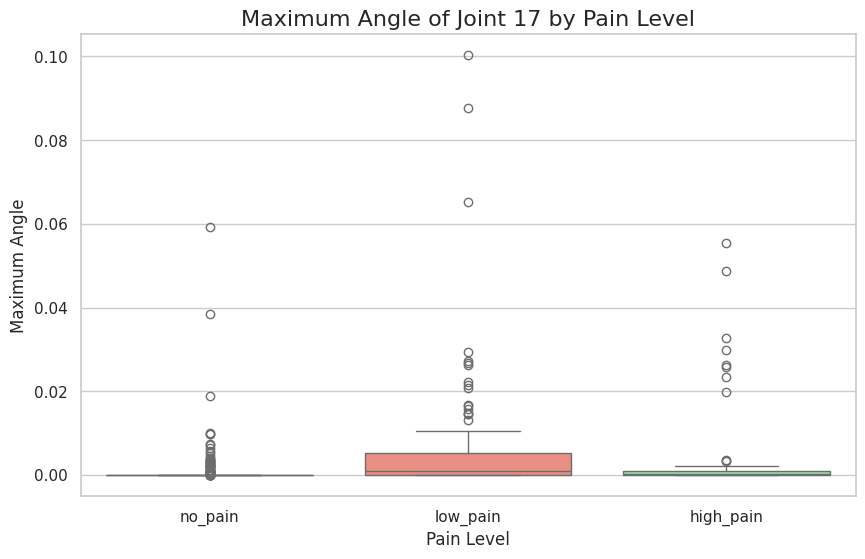


Mean of Standard Deviation for each pain level:
label
high_pain    0.000679
low_pain     0.000890
no_pain      0.000071
Name: joint_15_std, dtype: float64

Mean of Maximum Angle for each pain level:
label
high_pain    0.005097
low_pain     0.007042
no_pain      0.000518
Name: joint_15_max, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
palette = {"no_pain": "skyblue", "low_pain": "salmon", "high_pain": "lightgreen"}

# Check the engineered features for Joint 15
feature_to_check_std = 'joint_15_std'
feature_to_check_max = 'joint_15_max'

# Visualization of Box Plot for Standard Deviation
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_df, x='label', y=feature_to_check_std, palette=palette, order=['no_pain', 'low_pain', 'high_pain'])
plt.title(f'Standard Deviation of Joint 17 by Pain Level', fontsize=16)
plt.xlabel('Pain Level', fontsize=12)
plt.ylabel('Standard Deviation of Angle', fontsize=12)
plt.show()

# Visualization of Box Plot for Maximum Value
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_df, x='label', y=feature_to_check_max, palette=palette, order=['no_pain', 'low_pain', 'high_pain'])
plt.title(f'Maximum Angle of Joint 17 by Pain Level', fontsize=16)
plt.xlabel('Pain Level', fontsize=12)
plt.ylabel('Maximum Angle', fontsize=12)
plt.show()

print("\nMean of Standard Deviation for each pain level:")
print(final_df.groupby('label')[feature_to_check_std].mean())

print("\nMean of Maximum Angle for each pain level:")
print(final_df.groupby('label')[feature_to_check_max].mean())

# Validation

## Hold out

In [ ]:
#VALIDATION SPLIT
n_series = len(y_train)
VAL_SPLIT = 0.2
val_size = int(VAL_SPLIT * n_series)
train_size = n_series - val_size

sample_ids = y_train['sample_index'].unique()
random.seed(SEED)
random.shuffle(sample_ids)

train_samples = sample_ids[:train_size]
val_samples = sample_ids[train_size:]

print(f"Train samples {len(train_samples)}, validation samples {len(val_samples)}")

df_train = df[df['sample_index'].isin(train_samples)]
df_val = df[df['sample_index'].isin(val_samples)]

print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')

Train samples 529, validation samples 132
Training set shape: (81600, 34)
Validation set shape: (20000, 34)


## Stratified hold out

In [ ]:
#STRATIFIED VALIDATION
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

VAL_SPLIT = 0.15
SEED = 42

sample_ids = y_train["sample_index"].values
labels = y_train["label_encoded"].values

# Stratified split
sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=VAL_SPLIT,
    random_state=SEED
)

train_idx, val_idx = next(sss.split(sample_ids, labels))

train_samples = sample_ids[train_idx]
val_samples   = sample_ids[val_idx]

df_train = df[df["sample_index"].isin(train_samples)]
df_val   = df[df["sample_index"].isin(val_samples)]

## Validation with denoise

removing the pirates in the dataset that have the worst autocorrelations within their sequence

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def calculate_acf_score(series, min_lag=3, max_lag=20):
    """
    Calculates a score representing the strength of long-range autocorrelation.
    A higher score means more "test-like" structure.
    """
    try:
        acf_values = sm.tsa.acf(series.dropna(), nlags=max_lag, fft=True)

        relevant_acfs = np.abs(acf_values[min_lag : max_lag + 1])

        return np.mean(relevant_acfs)
    except Exception as e:
        return 0.0

def get_sample_score(df, idx, columns, max_lag):
    seq = df[df["sample_index"] == idx].sort_values(by='time').reset_index(drop=True)
    feature_scores = []
    for col in columns:
        c_seq = seq[col]
        score = calculate_acf_score(c_seq, max_lag=max_lag)
        feature_scores.append(score)
        #print(f"{col} = {score}")
    sequence_score = np.mean(feature_scores)
    #print(f"Sequence {idx} got {sequence_score}")
    return sequence_score

def get_top_testlike_sequences(df, columns, topk, max_lag):
    indexes = df['sample_index'].unique()
    all_scores = []
    for idx in indexes:
        score = get_sample_score(df, idx, columns, max_lag)
        all_scores.append((idx, score))

    all_scores.sort(key=lambda x: x[1], reverse=True)
    print(f"top5: {all_scores[:5]}")
    return [score[0] for score in all_scores[:topk]]

def get_worst_testlike_sequences(df, columns, topk, max_lag):
    indexes = df['sample_index'].unique()
    all_scores = []
    for idx in indexes:
        score = get_sample_score(df, idx, columns, max_lag)
        all_scores.append((idx, score))

    all_scores.sort(key=lambda x: x[1], reverse=False)
    print(f"bottom5: {all_scores[:5]}")
    print(f"top5 of the worst: {all_scores[topk-5:topk]}")
    return [score[0] for score in all_scores[:topk]]

def print_distr_info(df, columns, max_lag):
    indexes = df['sample_index'].unique()
    all_scores = []
    for idx in indexes:
        score = get_sample_score(df, idx, columns, max_lag)
        all_scores.append((idx, score))

    all_scores.sort(key=lambda x: x[1], reverse=True)
    curr_thresh = 0.40
    for i in range(len(all_scores)):
        if all_scores[i][1] < curr_thresh:
            print(f"{i}/{len(all_scores)} sequences have score > {curr_thresh}")
            curr_thresh -= 0.01
columns_nonoise = ['joint_00', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_09']

print_distr_info(df, columns_nonoise, 20)

29/661 sequences have score > 0.4
31/661 sequences have score > 0.39
32/661 sequences have score > 0.38
34/661 sequences have score > 0.37
35/661 sequences have score > 0.36
36/661 sequences have score > 0.35
38/661 sequences have score > 0.33999999999999997
39/661 sequences have score > 0.32999999999999996
42/661 sequences have score > 0.31999999999999995
47/661 sequences have score > 0.30999999999999994
52/661 sequences have score > 0.29999999999999993
58/661 sequences have score > 0.2899999999999999
63/661 sequences have score > 0.2799999999999999
69/661 sequences have score > 0.2699999999999999
75/661 sequences have score > 0.2599999999999999
77/661 sequences have score > 0.2499999999999999
83/661 sequences have score > 0.23999999999999988
92/661 sequences have score > 0.22999999999999987
96/661 sequences have score > 0.21999999999999986
100/661 sequences have score > 0.20999999999999985
104/661 sequences have score > 0.19999999999999984
115/661 sequences have score > 0.18999999999

In [ ]:
#Remove only BAD no pain pirates

# 1. Isolate the "no pain" data and the data for all other labels
print("Step 1: Separating 'no pain' data from other labels.")
df_no_pain = df[df['label_encoded'] == 2].copy()
df_other_labels = df[df['label_encoded'] != 2].copy()

print(f"Found {df_no_pain['sample_index'].nunique()} 'no pain' samples.")
print(f"Found {df_other_labels['sample_index'].nunique()} samples from other labels.")

# 2. Identify the worst sequences *only from the "no pain" data*
num_to_remove = 10
max_lag = 20 # Use the same max_lag as before

print(f"\nStep 2: Identifying the {num_to_remove} worst sequences from the 'no pain' class...")
bad_no_pain_samples = get_worst_testlike_sequences(
    df_no_pain,
    columns=columns_nonoise,
    topk=num_to_remove,
    max_lag=max_lag
)
print(f"Identified {len(bad_no_pain_samples)} 'no pain' samples to remove.")

# 3. Create a new "no pain" DataFrame that excludes these bad samples
print("\nStep 3: Filtering out the bad sequences.")
df_no_pain_cleaned = df_no_pain[~df_no_pain['sample_index'].isin(bad_no_pain_samples)]
print(f"Number of 'no pain' samples after cleaning: {df_no_pain_cleaned['sample_index'].nunique()}")

# 4. Recombine the cleaned "no pain" data with the untouched data from other labels
print("\nStep 4: Recombining cleaned data with data from other labels.")
df_final_cleaned = pd.concat([df_no_pain_cleaned, df_other_labels])

# Get the list of all unique sample IDs from our final curated dataset
final_samples_ids = df_final_cleaned['sample_index'].unique().tolist()

# Define the split ratio
VAL_SPLIT = 0.15
val_size = int(VAL_SPLIT * len(final_samples_ids))
train_size = len(final_samples_ids) - val_size

# Set the seed and shuffle the list of sample IDs for a random split
random.seed(SEED)
random.shuffle(final_samples_ids)

# Create the lists of sample IDs for each set
val_samples = final_samples_ids[:val_size]
train_samples = final_samples_ids[val_size:]

print(f"Total samples for splitting: {len(final_samples_ids)}")
print(f"Training samples: {len(train_samples)}")
print(f"Validation samples: {len(val_samples)}")

# Create the final DataFrames by filtering the cleaned data
df_train = df_final_cleaned[df_final_cleaned['sample_index'].isin(train_samples)]
df_val = df_final_cleaned[df_final_cleaned['sample_index'].isin(val_samples)]

print("\nSplitting complete. You can now use df_train and df_val.")


Step 1: Separating 'no pain' data from other labels.
Found 511 'no pain' samples.
Found 150 samples from other labels.

Step 2: Identifying the 10 worst sequences from the 'no pain' class...
bottom5: [(np.int64(597), np.float64(0.04973511216884951)), (np.int64(375), np.float64(0.049789861548818405)), (np.int64(423), np.float64(0.05038148919406974)), (np.int64(625), np.float64(0.05046179484984983)), (np.int64(154), np.float64(0.05116367941722483))]
top5 of the worst: [(np.int64(165), np.float64(0.051279499794994944)), (np.int64(379), np.float64(0.05161901960605314)), (np.int64(222), np.float64(0.05169870397434686)), (np.int64(639), np.float64(0.05193609779266919)), (np.int64(460), np.float64(0.052131467627380745))]
Identified 10 'no pain' samples to remove.

Step 3: Filtering out the bad sequences.
Number of 'no pain' samples after cleaning: 501

Step 4: Recombining cleaned data with data from other labels.
Total samples for splitting: 651
Training samples: 554
Validation samples: 97

S

top5: [(np.int64(596), np.float64(0.4955206255694403)), (np.int64(336), np.float64(0.45388825064841803)), (np.int64(164), np.float64(0.4476622082852037)), (np.int64(239), np.float64(0.40871972835365433)), (np.int64(418), np.float64(0.3975914413277497))]


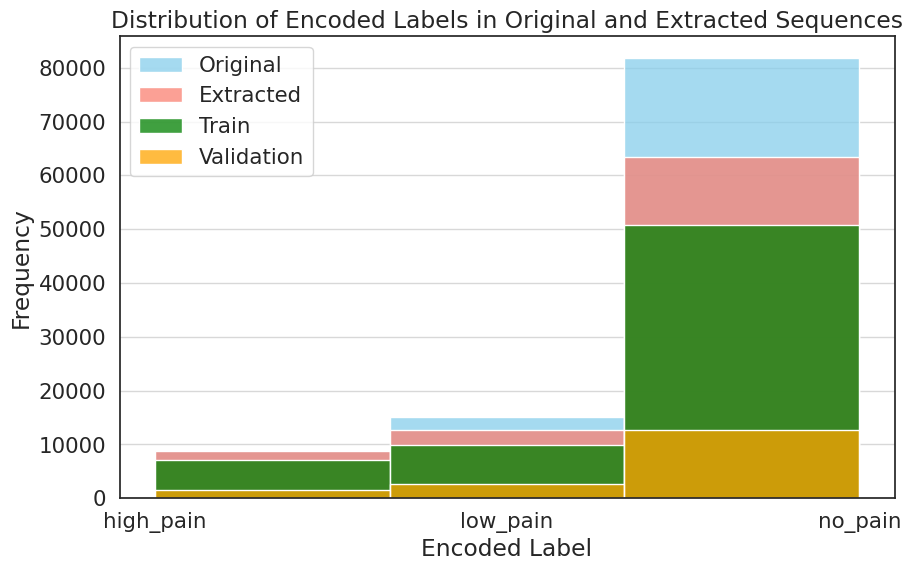

In [ ]:
columns_nonoise = ['joint_00', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_09', 'joint_13',
           'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_23', 'joint_24', 'joint_25']
#columns_nonoise = [col for col in df.columns if 'joint' in col]
#columns_nonoise.remove("joint_30")
#print(columns_nonoise)
good_samples = get_top_testlike_sequences(df, columns_nonoise, 300, 20)
#bad samples = get_worst_testlike_sequences(df, columns_nonoise, 200, 20)

df_top = df[df['sample_index'].isin(good_samples)]

VAL_SPLIT = 0.2
val_size = int(VAL_SPLIT * len(good_samples))
train_size = len(good_samples) - val_size

random.seed(SEED)
random.shuffle(good_samples)

val_samples = good_samples[:val_size]
train_samples = good_samples[val_size:]

df_train = df_top[df_top['sample_index'].isin(train_samples)]
df_val = df_top[df_top['sample_index'].isin(val_samples)]

plt.figure(figsize=(10, 6))

sns.histplot(df['label_encoded'], kde=False, bins=3, label='Original', color='skyblue')
sns.histplot(df_top['label_encoded'], kde=False, bins=3, label='Extracted', color='salmon')
sns.histplot(df_train['label_encoded'], kde=False, bins=3, label='Train', color='green')
sns.histplot(df_val['label_encoded'], kde=False, bins=3, label='Validation', color='orange')

plt.title('Distribution of Encoded Labels in Original and Extracted Sequences')
plt.xlabel('Encoded Label')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2], ['high_pain', 'low_pain', 'no_pain']) # Assuming this mapping based on previous output
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
columns_to_process = [
    'joint_00', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_09',
    'joint_13', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_23',
    'joint_24', 'joint_25'
]

# 1. The window size for extracting the long-term trend.
long_term_window = 50

alpha_dict = {
    'joint_00': 0.75,
    'joint_04': 0.82,
    'joint_05': 0.61,
    'joint_06': 0.82,
    'joint_07': 0.62,
    'joint_09': 0.82,
    'joint_13': 0.75,
    'joint_16': 0.81,
    'joint_17': 0.81,
    'joint_18': 0.87,
    'joint_19': 0.80,
    'joint_23': 0.77,
    'joint_24': 0.77,
    'joint_25': 0.75,

}
default_alpha = 0.8 # Use this for any joint not in the dictionary

print(f"Applying per-joint trend-noise recreation with window={long_term_window}...")

for col in columns_to_process:
    if col in df_train.columns:
        # Get the specific alpha for this column, or use the default
        alpha = alpha_dict.get(col, default_alpha)

        # Step 1: Extract the long-term trend
        long_term_trend = df_train.groupby('sample_index')[col].rolling(
            window=long_term_window, min_periods=1
        ).mean().reset_index(level=0, drop=True)

        # Step 2: Get the original signal
        original_signal = df_train[col]

        # Step 3: Blend using the specific alpha for this joint
        df_train[col] = (alpha * long_term_trend) + ((1 - alpha) * original_signal)

Applying per-joint trend-noise recreation with window=50...


# Data augmentation

### JITTER

Generation of new low pain samples taking the old ones and adding jitter

In [ ]:
joint_cols = [col for col in df_train.columns if col.startswith('joint_')]

# Calculate the standard deviation FOR EACH joint column across the entire training set
joint_stds = df_train[joint_cols].std()

print("Calculated Standard Deviations for each joint:")
print(joint_stds.head())

Calculated Standard Deviations for each joint:
joint_00    0.204284
joint_01    0.201133
joint_02    0.294445
joint_03    0.301513
joint_04    0.421129
dtype: float64


In [ ]:
def jitter_dynamic(sample_df, joint_stds, noise_fraction=0.02):
    """
    Adds Gaussian noise to the 'joint_' columns of a time-series sample,
    where the noise level is proportional to each joint's standard deviation.

    Args:
        sample_df (pd.DataFrame): DataFrame for a single sample.
        joint_stds (pd.Series): A Series containing the standard deviation for each joint column.
        noise_fraction (float): The fraction of the standard deviation to use as noise scale.
                                (e.g., 0.02 for 2%).

    Returns:
        pd.DataFrame: The augmented DataFrame with noise added.
    """
    augmented_sample = sample_df.copy()

    # Get the names of the joint columns present in this sample
    joint_cols_in_sample = [col for col in augmented_sample.columns if col.startswith('joint_')]

    # Apply noise to each joint column individually
    for col in joint_cols_in_sample:
        # Get the pre-calculated std for this specific joint
        std = joint_stds[col]

        # Calculate the noise scale for this column
        noise_scale = std * noise_fraction

        # Generate noise specifically for this column
        noise = np.random.normal(loc=0.0, scale=noise_scale, size=len(augmented_sample))

        # Add the noise
        augmented_sample[col] += noise

    return augmented_sample

In [ ]:

print("--- Before Augmentation ---")
print("Class distribution:")
print(df_train['label_encoded'].value_counts())
print("\nTotal samples:", df_train['sample_index'].nunique())
print("-" * 25)

# Class to augment: low pain
target_class = 1
# How many new samples to create for each original one
augmentation_factor = 3

# Get the unique sample indices for the target class
indices_to_augment = df_train[df_train['label_encoded'] == target_class]['sample_index'].unique()

augmented_samples = []
new_sample_index_start = df_train['sample_index'].max() + 1

for i in range(augmentation_factor):
    for sample_idx in indices_to_augment:
        original_sample = df_train[df_train['sample_index'] == sample_idx]

        new_sample = jitter_dynamic(original_sample, joint_stds, noise_fraction=0.02) # Using 2% noise

        new_sample['sample_index'] = new_sample_index_start
        new_sample_index_start += 1
        augmented_samples.append(new_sample)

# Combine Datasets
if augmented_samples:
    augmented_df = pd.concat(augmented_samples, ignore_index=True)

    df_final = pd.concat([df_train, augmented_df], ignore_index=True)
else:
    print("No samples found for the target class to augment.")
    df_final = df_train

print("\n--- After Augmentation ---")
print("Class distribution:")
print(df_final['label_encoded'].value_counts())
print("\nTotal samples:", df_final['sample_index'].nunique())
print("-" * 25)

df_train = df_final

--- Before Augmentation ---
Class distribution:
label_encoded
2    65440
1    12000
0     7200
Name: count, dtype: int64

Total samples: 529
-------------------------

--- After Augmentation ---
Class distribution:
label_encoded
2    65440
1    48000
0     7200
Name: count, dtype: int64

Total samples: 754
-------------------------


In [ ]:
print("\nTotal samples:", df_train['sample_index'].nunique())


Total samples: 754


# SCALING

## Standard scaler

In [ ]:
from sklearn.preprocessing import StandardScaler

scale_columns = [col for col in df_train.columns if col.startswith('joint')]

scaler = StandardScaler()
scaler.fit(df_train[scale_columns])

df_train[scale_columns] = scaler.transform(df_train[scale_columns])
df_val[scale_columns] = scaler.transform(df_val[scale_columns])
X_test[scale_columns] = scaler.transform(X_test[scale_columns])

print("Data has been scaled using StandardScaler.")
print(df_train[scale_columns].describe())

Data has been scaled using StandardScaler.
           joint_00      joint_01      joint_02      joint_03      joint_04  \
count  8.464000e+04  8.464000e+04  8.464000e+04  8.464000e+04  8.464000e+04   
mean  -7.078564e-16 -5.708519e-16  4.499656e-17 -8.327722e-17 -1.410340e-16   
std    1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min   -4.607484e+00 -4.557065e+00 -2.637899e+00 -2.525418e+00 -1.676091e+00   
25%   -5.664331e-01 -5.296663e-01 -7.227445e-01 -8.309721e-01 -1.252944e+00   
50%    3.082015e-01  3.182269e-01  4.371344e-01  4.920138e-01  5.262460e-01   
75%    6.807630e-01  7.074854e-01  7.361572e-01  7.586925e-01  7.861568e-01   
max    2.284749e+00  2.078457e+00  1.793758e+00  1.618121e+00  1.551453e+00   

           joint_05      joint_06      joint_07      joint_08      joint_09  \
count  8.464000e+04  8.464000e+04  8.464000e+04  8.464000e+04  8.464000e+04   
mean  -1.880453e-17 -2.471453e-16  4.419065e-16 -5.137667e-17 -1.638681e-16   
std    1

In [ ]:
pd.set_option('display.max_columns', None)
df.describe()

sample_index           time  pain_survey_1  pain_survey_2  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean      330.000000      79.500000       1.633746       1.654851   
std       190.814948      46.187338       0.682423       0.669639   
min         0.000000       0.000000       0.000000       0.000000   
25%       165.000000      39.750000       2.000000       2.000000   
50%       330.000000      79.500000       2.000000       2.000000   
75%       495.000000     119.250000       2.000000       2.000000   
max       660.000000     159.000000       2.000000       2.000000   

       pain_survey_3  pain_survey_4       joint_00       joint_01  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean        1.653640       1.663134       0.943095       0.916955   
std         0.666649       0.661994       0.202051       0.197608   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       2.000000       0.828277       0.811445   
50%         2.000000       2.000000       1.005126       0.979468   
75%         2.000000       2.000000       1.081039       1.056611   
max         2.000000       2.000000       1.407968       1.334613   

            joint_02       joint_03       joint_04       joint_05  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean        0.779296       0.767921       0.709186       0.711306   
std         0.295605       0.300787       0.418058       0.411783   
min         0.001015       0.005403       0.000000       0.000000   
25%         0.568850       0.520020       0.184585       0.210551   
50%         0.909549       0.914834       0.930007       0.950628   
75%         0.995187       0.994324       1.036497       1.032400   
max         1.306046       1.254729       1.359204       1.387731   

            joint_06       joint_07       joint_08       joint_09  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean        0.875185       0.837427       0.849700       0.909554   
std         0.240900       0.237904       0.180489       0.180320   
min         0.000000       0.000000       0.122095       0.004671   
25%         0.839166       0.781375       0.717725       0.825898   
50%         0.937363       0.904914       0.831221       0.940954   
75%         1.013150       0.984410       0.991104       1.030941   
max         1.410532       1.361969       1.357288       1.388105   

            joint_10       joint_11       joint_12       joint_13  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean        0.694840       0.691105       1.047287       0.000092   
std         0.257572       0.262645       0.110834       0.001202   
min         0.107917       0.072233       0.107136       0.000000   
25%         0.469688       0.460407       0.983152       0.000000   
50%         0.690806       0.705150       1.057917       0.000001   
75%         0.866482       0.851772       1.124471       0.000006   
max         1.631494       1.464157       1.396754       0.073852   

           joint_14      joint_15      joint_16       joint_17       joint_18  \
count  1.057600e+05  1.057600e+05  1.057600e+05  105760.000000  105760.000000   
mean   8.068677e-05  1.038032e-04  1.085133e-04       0.000351       0.000293   
std    1.481660e-03  1.287669e-03  1.628836e-03       0.004383       0.004987   
min    2.763050e-07  0.000000e+00  0.000000e+00       0.000000       0.000000   
25%    6.538634e-07  0.000000e+00  5.348361e-07       0.000000       0.000000   
50%    2.165072e-06  7.069540e-07  1.825457e-06       0.000002       0.000001   
75%    6.396479e-06  5.481908e-06  6.550744e-06       0.000019       0.000015   
max    2.642323e-01  1.003470e-01  1.888070e-01       0.420947       0.728382   

            joint_19       joint_20      joint_21      joint_22      joint_23  \
count  105760.000000  105760.000000  1.057600e+05  1.057600e+05  1.057600e+05   
mean  

## Robust scaler

In [ ]:
from sklearn.preprocessing import RobustScaler

scale_columns = [col for col in df_train.columns if col.startswith('joint')]

#scaler = RobustScaler(quantile_range=(10.0, 90.0))
scaler = RobustScaler()
scaler.fit(df_train[scale_columns])

df_train[scale_columns] = scaler.transform(df_train[scale_columns])
df_val[scale_columns] = scaler.transform(df_val[scale_columns])
X_test[scale_columns] = scaler.transform(X_test[scale_columns])

print("Scaling complete using RobustScaler.")
print("\nFirst 5 rows of scaled df_train:")
print(df_train[scale_columns].head())

Scaling complete using RobustScaler.

First 5 rows of scaled df_train:
   joint_00  joint_01  joint_02  joint_03  joint_04  joint_05  joint_06  \
0  0.355257  0.018910  0.260041  0.198602  0.051536  0.091795 -0.214156   
1  0.514130  0.163162  0.204267  0.286186  0.084407  0.079844 -0.085956   
2  0.300463 -0.071265  0.239755  0.129301  0.066701  0.088969  0.230161   
3 -0.259736  0.405968  0.212828  0.150403 -0.003845  0.068031 -0.634482   
4  0.337515  0.207248  0.237712  0.101112  0.103443  0.102740  0.108059   

   joint_07  joint_08  joint_09  ...  joint_21  joint_22  joint_23  joint_24  \
0  0.463565 -0.413216  0.536020  ...  1.025273  0.332337  1.146032  4.986418   
1  0.648496 -0.377208  0.584182  ... -0.151532 -0.146611  1.917252 -0.373806   
2  0.837054 -0.580134  0.352626  ... -0.244221 -0.337906  0.171155  0.735939   
3  0.877952 -0.453712  0.522199  ...  3.517499 -0.193959  0.324457 -0.370125   
4  0.404105 -0.416159  0.510399  ...  1.381027 -0.336511  0.211880 -0.368292  

In [ ]:
#ROBUST + CLIPPING AFTER
scale_columns = [col for col in df_train.columns if col.startswith('joint')]

from sklearn.preprocessing import RobustScaler

SAFE_RANGE = 10.0

for c in scale_columns:
    print(f"scaling {c}")
    scaler = RobustScaler()
    # Reshape the Series to a 2D array (-1, 1) before fitting and transforming
    df_train[c] = scaler.fit_transform(df_train[c].values.reshape(-1, 1)).flatten()
    df_val[c] = scaler.transform(df_val[c].values.reshape(-1, 1)).flatten()
    X_test[c] = scaler.transform(X_test[c].values.reshape(-1, 1)).flatten()

    if df_train[c].abs().max() > SAFE_RANGE:
      print(f"Clipping {c}: [{df_train[c].min()}, {df_train[c].max()}]")
      df_train[c] = df_train[c].clip(-SAFE_RANGE, SAFE_RANGE)
      df_val[c] = df_val[c].clip(-SAFE_RANGE, SAFE_RANGE)
      X_test[c] = X_test[c].clip(-SAFE_RANGE, SAFE_RANGE)

scaling joint_00
scaling joint_01
scaling joint_02
scaling joint_03
scaling joint_04
scaling joint_05
scaling joint_06
scaling joint_07
scaling joint_08
scaling joint_09
scaling joint_10
scaling joint_11
scaling joint_12
scaling joint_13
Clipping joint_13: [-0.19903509603115732, 3606.1872754559486]
scaling joint_14
Clipping joint_14: [-0.2469083495285303, 15046.264047788725]
scaling joint_15
Clipping joint_15: [-0.22273699544469766, 7817.50524407449]
scaling joint_16
Clipping joint_16: [-0.30463749093121334, 14557.220541483539]
scaling joint_17
Clipping joint_17: [-0.24975187621937836, 12879.408810022253]
scaling joint_18
Clipping joint_18: [-0.23960654067192796, 27063.79775146057]
scaling joint_19
Clipping joint_19: [-0.3088849114339182, 22088.085742039704]
scaling joint_20
Clipping joint_20: [-0.2659106088146499, 26356.371410200038]
scaling joint_21
Clipping joint_21: [-0.2685069962387285, 214578.49225198358]
scaling joint_22
Clipping joint_22: [-0.29900792857235065, 209154.691058692

In [ ]:
#ROBUST SCALER WITH CLIPPING BEFORE SCALING
scale_columns = [col for col in df.columns if col.startswith('joint')]

scalers = {}

for c in scale_columns:
    print(f"Processing {c}")
    # calculate bounds
    lower_bound = df[c].quantile(0.01)
    upper_bound = df[c].quantile(0.99)

    print(f"  - Clipping '{c}' between {lower_bound:.4f} and {upper_bound:.4f}")

    # Clip all datasets using these bounds
    df[c]     = df[c].clip(lower_bound, upper_bound)
    df_val[c] = df_val[c].clip(lower_bound, upper_bound)
    X_test[c] = X_test[c].clip(lower_bound, upper_bound)

    # Fit scaler on clipped training data and transform all sets
    scaler = RobustScaler()
    df[c] = scaler.fit_transform(df[[c]])
    df_val[c] = scaler.transform(df_val[[c]])
    X_test[c] = scaler.transform(X_test[[c]])

    scalers[c] = scaler

## Minmax

In [ ]:
scale_columns = [col for col in df_train.columns if col.startswith('joint')]

mins = df_train[scale_columns].min()
maxs = df_train[scale_columns].max()

for c in scale_columns:
  df_train[c] = (df_train[c] - mins[c]) / (maxs[c] - mins[c])
  df_val[c] = (df_val[c] - mins[c]) / (maxs[c] - mins[c])
  X_test[c] = (X_test[c] - mins[c]) / (maxs[c] - mins[c])

  print(f"Min {c}: {mins[c]}, Max {c}: {maxs[c]}")

Min joint_00: 0.0, Max joint_00: 1.407968102920364
Min joint_01: 0.0, Max joint_01: 1.33461309026345
Min joint_02: 0.001175540071103, Max joint_02: 1.2370871942941035
Min joint_03: 0.005403208977202, Max joint_03: 1.254728584640333
Min joint_04: 0.0, Max joint_04: 1.3592041906601298
Min joint_05: 0.0, Max joint_05: 1.3877310476309013
Min joint_06: 0.0, Max joint_06: 1.4105319672746472
Min joint_07: 0.0, Max joint_07: 1.3619686012219738
Min joint_08: 0.2059824975044532, Max joint_08: 1.3572876989947114
Min joint_09: 0.1236058745542073, Max joint_09: 1.38810451581177
Min joint_10: 0.1176205741021279, Max joint_10: 1.631494436951367
Min joint_12: 0.4939390285906562, Max joint_12: 1.3967536513367282
Min joint_13: 0.0, Max joint_13: 0.0638035597623482
Min joint_14: 2.763049739186912e-07, Max joint_14: 0.0668803341160854
Min joint_15: 0.0, Max joint_15: 0.0651752777784983
Min joint_16: 0.0, Max joint_16: 0.0676551392924203
Min joint_17: 0.0, Max joint_17: 0.1796810098246442
Min joint_18: 0.0

## Other scalers

In [ ]:
#LOG TRANSFORMATION + STANDARD SCALER
import numpy as np
from sklearn.preprocessing import StandardScaler

scale_columns = [col for col in df_train.columns if col.startswith('joint')]

# Apply log transformation
for col in scale_columns:
    df_train[col] = np.log1p(df_train[col])
    df_val[col] = np.log1p(df_val[col])
    X_test[col] = np.log1p(X_test[col])

# Apply StandardScaler
scaler = StandardScaler()
df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
df_val[scale_columns] = scaler.transform(df_val[scale_columns])
X_test[scale_columns] = scaler.transform(X_test[scale_columns])

In [ ]:
# POWER TRANSFORMER SCALER
from sklearn.preprocessing import PowerTransformer

scale_columns = [col for col in df_train.columns if col.startswith('joint')]

# Use the Yeo-Johnson method as it handles zeros perfectly
scaler = PowerTransformer(method='yeo-johnson', standardize=True)

df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
df_val[scale_columns] = scaler.transform(df_val[scale_columns])
X_test[scale_columns] = scaler.transform(X_test[scale_columns])


In [ ]:
for col in scale_columns[0:30]:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_train[col], color="skyblue", label="Train", kde=True, stat="density", common_norm=False)
    sns.histplot(X_test[col], color="salmon", label="Test", kde=True, stat="density", common_norm=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Sequences autocorrelation test

n_timesteps: 160

--- Organized ACF Results DataFrame ---
                   Lag_0     Lag_1     Lag_2     Lag_3     Lag_4     Lag_5  \
Sequence Feature                                                             
0        joint_00    1.0  0.015768 -0.057600  0.006504 -0.097815 -0.082054   
         joint_01    1.0 -0.029090 -0.027680 -0.000807 -0.092867 -0.040567   
         joint_02    1.0 -0.020838  0.068987 -0.045559 -0.040271  0.021837   
         joint_03    1.0  0.030214 -0.019679 -0.123446 -0.088830 -0.078462   
         joint_04    1.0  0.009352 -0.135360  0.045693  0.013728 -0.030355   

                      Lag_6     Lag_7     Lag_8     Lag_9  ...    Lag_41  \
Sequence Feature                                           ...             
0        joint_00 -0.032215  0.008696  0.051419  0.024727  ...  0.045807   
         joint_01 -0.170893 -0.132267  0.046599  0.093305  ... -0.006202   
         joint_02 -0.065952  0.001397  0.069460 -0.027441  ... -0.124633   
         joint_

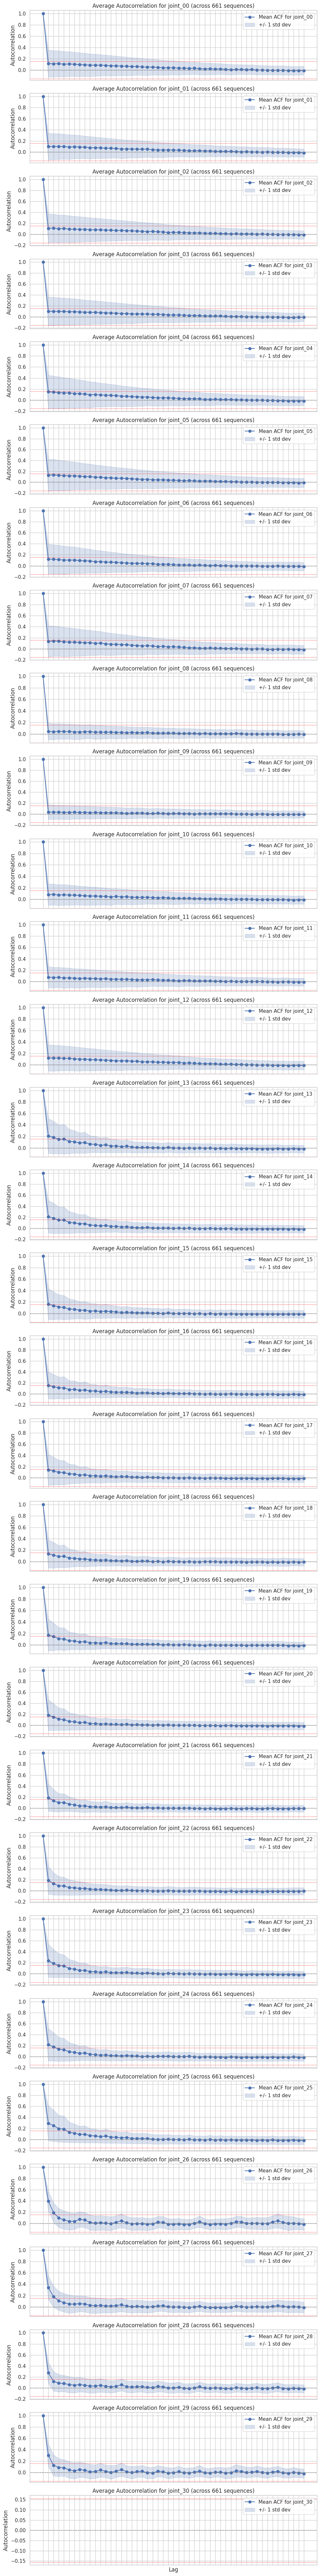

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

nlags = 50

acf_results = {}

columns = [col for col in df.columns if col.startswith('joint')]
n_features = len(columns)
feature_names = columns

indexes = df["sample_index"].unique()

n_sequences = len(indexes)
n_timesteps = len(df[df["sample_index"] == 1])
print(f"n_timesteps: {n_timesteps}")

for idx in indexes:
  seq = df[df["sample_index"] == idx].sort_values(by='time').reset_index(drop=True)

  for col in columns:
    c_seq = seq[col]
    acf_values = sm.tsa.acf(c_seq, nlags=nlags, fft=True)
    acf_results[(idx, col)] = acf_values

results_df = pd.DataFrame.from_dict(acf_results, orient='index')

results_df.columns = [f'Lag_{i}' for i in range(nlags + 1)]

# Create a MultiIndex from the tuple-based index for powerful slicing and grouping
results_df.index = pd.MultiIndex.from_tuples(
    results_df.index,
    names=['Sequence', 'Feature']
)

print("\n--- Organized ACF Results DataFrame ---")
print(results_df.head())

# Aggregate by grouping by the 'Feature' level of the index
# This gives the average ACF for each feature across all sequences
mean_acf_df = results_df.groupby('Feature').mean()
std_acf_df = results_df.groupby('Feature').std()

print("\n--- Mean ACF across all sequences for each feature ---")
print(mean_acf_df)

# Create a plot showing the average ACF for each feature
fig, axes = plt.subplots(n_features, 1, figsize=(10, 80), sharex=True)
if n_features == 1: # Matplotlib returns a single ax object if nrows=1
    axes = [axes]

for i, feature in enumerate(feature_names):
    ax = axes[i]
    mean_acf = mean_acf_df.loc[feature]
    std_acf = std_acf_df.loc[feature]

    ax.plot(mean_acf.index, mean_acf.values, marker='o', linestyle='-', label=f'Mean ACF for {feature}')

    # Create a shaded confidence interval (mean +/- 1 standard deviation)
    ax.fill_between(
        std_acf.index,
        (mean_acf - std_acf),
        (mean_acf + std_acf),
        color='b',
        alpha=0.2,
        label='+/- 1 std dev'
    )

    ax.axhline(0, linestyle='--', color='gray', linewidth=1)
    conf_interval = 1.96 / np.sqrt(n_timesteps)
    ax.axhline(conf_interval, linestyle=':', color='red', linewidth=1)
    ax.axhline(-conf_interval, linestyle=':', color='red', linewidth=1)

    ax.set_title(f'Average Autocorrelation for {feature} (across {n_sequences} sequences)')
    ax.set_ylabel('Autocorrelation')
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Lag')
lag_labels = [col.replace('_', ' ') for col in mean_acf_df.columns]
plt.xticks(ticks=range(nlags + 1), labels=lag_labels, rotation=90)
for ax in axes:
    plt.setp(ax.get_xticklabels(), visible=False)
    for label in ax.get_xticklabels()[::5]:
        label.set_visible(True)
plt.setp(axes[-1].get_xticklabels(), visible=True)


plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

nlags = 50

acf_results = {}

df = pirate_pain_train
columns = [col for col in df.columns if col.startswith('joint')]
n_features = len(columns)
feature_names = columns

indexes = df["sample_index"].unique()

n_sequences = len(indexes)
n_timesteps = len(df[df["sample_index"] == 1])
print(f"n_timesteps: {n_timesteps}")

for idx in indexes:
  seq = df[df["sample_index"] == idx].sort_values(by='time').reset_index(drop=True)

  for col in columns:
    c_seq = seq[col]
    acf_values = sm.tsa.acf(c_seq, nlags=nlags, fft=True)
    acf_results[(idx, col)] = acf_values

results_df = pd.DataFrame.from_dict(acf_results, orient='index')

# Improve the column names
results_df.columns = [f'Lag_{i}' for i in range(nlags + 1)]

# Create a MultiIndex from the tuple-based index for powerful slicing and grouping
results_df.index = pd.MultiIndex.from_tuples(
    results_df.index,
    names=['Sequence', 'Feature']
)

# Display the first few rows of our organized results
print("\n--- Organized ACF Results DataFrame ---")
print(results_df.head())

# --- Aggregate by grouping by the 'Feature' level of the index ---
# This gives you the average ACF for each feature across all sequences
mean_acf_df = results_df.groupby('Feature').mean()
std_acf_df = results_df.groupby('Feature').std()

print("\n--- Mean ACF across all sequences for each feature ---")
print(mean_acf_df)

# --- Visualize the aggregated results ---
# Create a plot showing the average ACF for each feature
fig, axes = plt.subplots(n_features, 1, figsize=(10, 80), sharex=True)
if n_features == 1: # Matplotlib returns a single ax object if nrows=1
    axes = [axes]

for i, feature in enumerate(feature_names):
    ax = axes[i]
    mean_acf = mean_acf_df.loc[feature]
    std_acf = std_acf_df.loc[feature]

    ax.plot(mean_acf.index, mean_acf.values, marker='o', linestyle='-', label=f'Mean ACF for {feature}')

    # Create a shaded confidence interval (mean +/- 1 standard deviation)
    ax.fill_between(
        std_acf.index,
        (mean_acf - std_acf),
        (mean_acf + std_acf),
        color='b',
        alpha=0.2,
        label='+/- 1 std dev'
    )

    ax.axhline(0, linestyle='--', color='gray', linewidth=1)
    # Add lines for standard confidence interval (approximate)
    # The formula is 1.96 / sqrt(N) for 95% CI
    conf_interval = 1.96 / np.sqrt(n_timesteps)
    ax.axhline(conf_interval, linestyle=':', color='red', linewidth=1)
    ax.axhline(-conf_interval, linestyle=':', color='red', linewidth=1)

    ax.set_title(f'Average Autocorrelation for {feature} (across {n_sequences} sequences)')
    ax.set_ylabel('Autocorrelation')
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Lag')
# Use the string lag names for x-axis ticks
lag_labels = [col.replace('_', ' ') for col in mean_acf_df.columns]
plt.xticks(ticks=range(nlags + 1), labels=lag_labels, rotation=90)
# Show every 5th tick to avoid clutter
for ax in axes:
    plt.setp(ax.get_xticklabels(), visible=False)
    for label in ax.get_xticklabels()[::5]:
        label.set_visible(True)
plt.setp(axes[-1].get_xticklabels(), visible=True)


plt.tight_layout()
plt.show()

Checking ACF function for a single series of a single joint

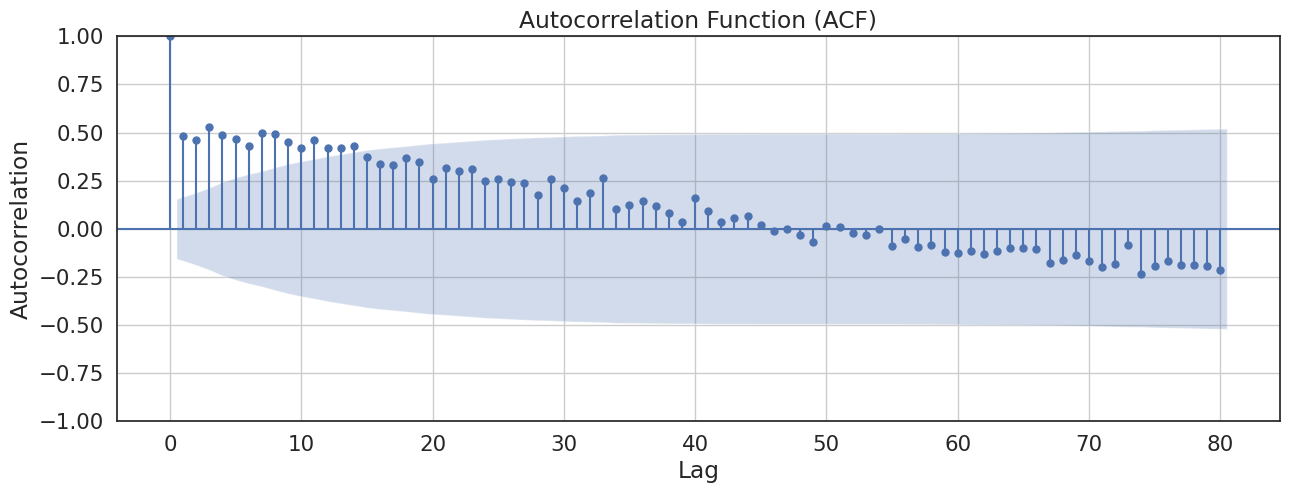

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_acf
sample_id = 336
joint_to_analyze = 'joint_00'

series = df[df['sample_index'] == sample_id][['time', joint_to_analyze]].set_index('time')
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(series[joint_to_analyze], lags=80, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

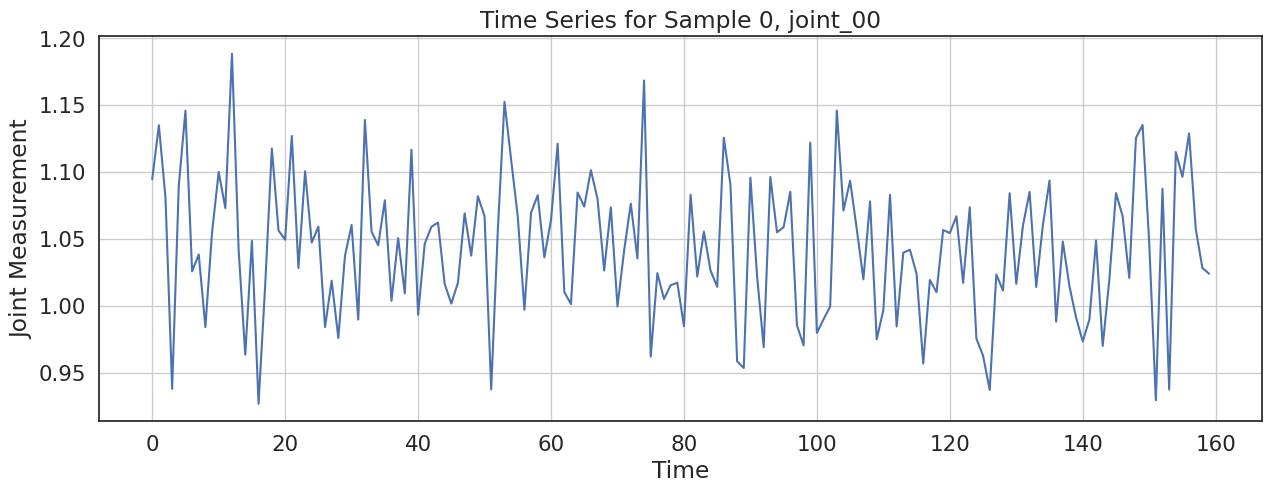

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_acf
sample_id = 0
joint_to_analyze = 'joint_00'

# Create a new dataframe for our single time series
series = df[df['sample_index'] == sample_id][['time', joint_to_analyze]].set_index('time')

plt.figure(figsize=(15, 5))
plt.plot(series.index, series[joint_to_analyze])
plt.title(f'Time Series for Sample {sample_id}, {joint_to_analyze}')
plt.xlabel('Time')
plt.ylabel('Joint Measurement')
plt.grid(True)
plt.show()